# Supervised Learning for HR Separations
## August 4, 2015
<hr>

### 1. Load the dataset processed in Supervised Learning HR Separation v1.1
* filename is employee_dataframe9.tsv
* try to use bear
* step through the columns in a logical way that I did in early to mid July, 2015.
* (no longer do I need to labelEncode GRADE)
* use bear
#### define the source repo
* '/home/kesj/lib/repo/'

### 2. Define the correct working directories
* '/data/discovery/hrsepara/core/' for HDFS
* '/data/discovery/hrsepara/staging/eda' and '/home/kesj/working/hrsepara/eda/' for HDFS and LFS on phd


In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'
repodir = '/home/kesj/lib/repo/'

In [2]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')


In [3]:
os.chdir(repodir)
import bear.bear as br

In [4]:
os.chdir(stgdir1local)

## Begin by loading the source dataframe file
#### filename is employee_dataframe9.tsv
#### This has been modified from employee_dataframe.ssv in the following ways.
* negative TOT_MO_SERVICE_SFI have been removed
* GRADE = 'UNS', '' have been removed
* STATE_LOC of 'ON' have been removed
* 'retired' have been identified from the ACTRES1 messages.
* Benefits (i.e. have_ins and have_dep) info has been joined into this dataset.
    1. missing values zeroed out 
* unempl_rate (at time of departure or current date) applied
* Some features (columns) cleaned and encoded by scikitlearn label encode (N--> 0, Y-->1):
    1. POSTAL_SFI --> zip5
    2. VOLINVOL --> sep_status (0,1,2,3)
    3. MAR_STA_SNAME_SFI --> mar_status (0,1,2)
    4. SEX --> Male (1,0): M=1,F=0
    5. COMP_FREQUENCY --> hourly_comp (1,0): H=1, A = 0
    6. RATE* using the dictionary provided by Ron Davis to 3 levels: low, medium, High
    7. BOX* columns using this mapping: BOX columns:  L -> 1, S -> 2, H -> 3
        -- still need to apply the mapping of missing to 0.
    8. FLSA_STATUS: map N: 0, Z: 1, X: -1
    9. SHIFT: map 'N' to 0; rest same (arity=4)

In [5]:
datafile = 'employee_dataframe9.tsv'
empl_bene = pd.read_csv(datafile,sep='\t',dtype={'KEY':np.str,'zip5':np.str,'SKEY':np.str})
empl_bene.drop('Unnamed: 0',axis=1,inplace=True)
# drop per_org --> universally EMP
empl_bene.drop('PER_ORG',axis=1,inplace=True)
print empl_bene.shape

(199346, 188)


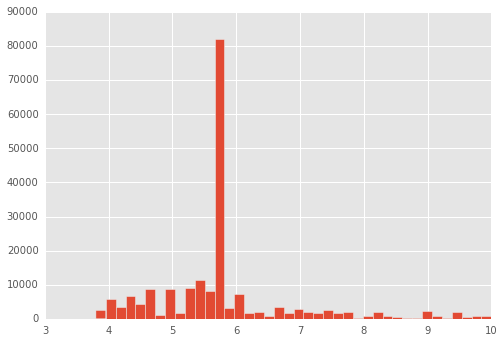

In [6]:
empl_bene.unempl_rate.hist(bins=40)

### Fix the BOX columns missing values as 0
* note I may want to remove this step from this place in the workflow and let bear fix it

In [7]:
## Fix the BOX columns missing as 0
box_col_list = [x for x in empl_bene.columns if x.startswith('BOX')]
#empl_bene[box_col_list].fillna(0,inplace=True)#.head()
# replace the boxes with 0 
#chg_to_zero_cols = ['BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
#for box_col in box_col_list: #chg_to_zero_cols:
#    empl_bene.fillna({box_col: 0},inplace=True)

## remove Rows (i.e. employees ) corresponding to certain characteristics
1. keep only those that are known (vol,invol, not) per discussion on April 22, 2015
2. remove grades starting with 'L' and 'AT'
    * As we discussed, I'm already excluding seasonal employees, interns, and agency interns. 
    * Let’s also exclude the L-Level executive employees are in the LDSH job group with job grades L1 to L10 (i.e., all job grades starting with “L”). 
    * Let’s also exclude Air Transportation as we don’t foresee applying the model to them either. Their job group is AIRT with job grades AT1 to AT8 (i.e., all job grades starting with “AT”).
3. take a time slice --> only after 01-01-2002
 



In [8]:
# remove sep_status over 1
empl_bene = empl_bene[empl_bene.sep_status<=2]
print np.shape(empl_bene)

(198531, 188)


In [9]:
# remove AT* and L* grades
list_of_grades = empl_bene.GRADE.unique()
print len(list_of_grades)
grades_to_drop = [x for x in map(str,list_of_grades) if (x.startswith('L') or x.startswith('AT'))]
print len(grades_to_drop)
grades_to_drop.remove('LS2')
grades_to_drop.remove('LS1')
grades_to_drop.remove('LS3')
grades_to_drop.remove('LM1')
grades_to_drop.remove('LM2')
grades_to_drop.remove('LP1')
print len(grades_to_drop),grades_to_drop

164
24
18 ['L5', 'L7', 'L6', 'L9', 'L10', 'AT5', 'L8', 'L4', 'AT7', 'AT2', 'L2', 'L3', 'AT3', 'L1', 'AT1', 'AT6', 'AT4', 'AT8']


In [10]:
print "removing these {0} grades removes {1} employees".format(len(grades_to_drop),len(empl_bene[empl_bene.GRADE.isin(grades_to_drop)]))
empl=empl_bene[~empl_bene.GRADE.isin(grades_to_drop)].copy()
print np.shape(empl)

removing these 18 grades removes 581 employees
(197950, 188)


### Create a column for terminated (i.e separated but not Retired)
* requires that status == 1 but retired == 0

In [11]:
## create a column for terminated (i.e. separated but NOT retired)
empl['terminated']= 0
my_rows = empl[(empl.status==1) & (empl.retired==0)].index
print "Out of {0} rows, {1} are separated and not retired.".format(len(empl),len(my_rows))
#sum(empl_df['terminated']))#, len(my_rows)
empl.loc[my_rows,'terminated']=1
print sum(empl.terminated)

Out of 197950 rows, 105236 are separated and not retired.
105236


In [12]:
pd.crosstab(empl.status, empl.retired)

retired,0,1
status,,
0,69475,1
1,105236,23238


## the one case where the person is 'retired' but has status of 0 is wrong -- I'm removing this row.

In [14]:
wrong_status_idx = empl[(empl.status == 0)& (empl.retired == 1)].index[0]
print wrong_status_idx

50687


In [20]:
empl.drop(empl.index[wrong_status_idx],inplace=True)
print np.shape(empl)

(197949, 189)


## Create subset that is based upon those after a given date
specifically January 1, 2002

In [21]:
date0 = '2002-01-01'
em2002 = empl.ix[empl.TERMINATION_DT>=date0].copy()
print date0, len(em2002)
print "--------- STATUS "
print em2002.status.value_counts()
print "--------- TERMINATED"
print em2002.terminated.value_counts()
print "--------- RETIRED"
print em2002.retired.value_counts()
print np.shape(em2002)

2002-01-01 134236
--------- STATUS 
0    69476
1    64760
dtype: int64
--------- TERMINATED
0    84592
1    49644
dtype: int64
--------- RETIRED
0    119119
1     15117
dtype: int64
(134236, 189)


# Tweak some of the columns
1. convert tenure_months into tenure Years  and drop the tenure_months columns. Tenure in years is just easier to think about.
2. create timestamps for columns that are timestamps 
3. create a value for the age at hire (hire_age)

In [22]:
print np.shape(em2002)
em2002['Tenure_years'] = em2002['Tenure_months']/12.
em2002.drop('Tenure_months',axis=1,inplace=True)


(134236, 189)


In [23]:
## create timestamps for columns that are timestamps
em2002[['hire_tstmp','term_tstmp','birth_tstmp']] = em2002[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x:pd.to_datetime(x))
## add a column for age at hire date
hire_age_tdelta = em2002['hire_tstmp']-em2002['birth_tstmp']
# convert to days, months, or years
em2002['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')



###Assign random indices to this data frame

In [24]:
list_of_indices = list(range(em2002.KEY.nunique()))
print len(list_of_indices )
random.seed(833311)
#new_indices = [x for x in random.shuffle(list_of_indices)
random.shuffle(list_of_indices)#, len(list_of_indices))
em2002.index = list_of_indices # note that random.shuffle does this shuffling inplace
em2002.sort_index(inplace=True)
em2002.head()

134236


,ACTRES1,ACTRES10,ACTRES2,ACTRES3,ACTRES4,ACTRES5,ACTRES6,ACTRES7,ACTRES8,ACTRES9,...,sep_status,mar_status,retired,unempl_rate,terminated,Tenure_years,hire_tstmp,term_tstmp,birth_tstmp,hire_age
0,NO REASON GIVEN,NaN,EMPLOYEE NEW HIRE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,0,8.0,1,0.238198,2012-11-05,2013-01-31,1987-04-16,25.558362
1,EMPLOYEE NEW HIRE;LOCATION/FLOOR CHANGE;JOB RE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,1,0,4.6,1,0.216295,2007-04-09,2007-06-27,1980-09-24,26.538533
2,NO REASON GIVEN,EMPLOYEE NEW HIRE;TRANSFER W/O JOB NUMBER CHANGE,TRANSFER W/O JOB NUMBER CHANGE;MERIT;JOB RECLA...,TRANSFER W/O JOB NUMBER CHANGE;MERIT;JOB RECLA...,REVIEW DATE CHANGE;TRANSFER W/O JOB NUMBER CHA...,COMPANY WIDE CONVERSION;REGIONAL CONVERSION;CO...,TRANSFER W/ JOB NUMBER CHANGE;TRANSFER W/O JOB...,MERIT;COST OF LIVING ADJUSTMENT;TRANSFER W/O J...,TRANSFER W/O JOB NUMBER CHANGE;PROMOTION WITH ...,MERIT;JOB CODE CHANGE;MERIT,...,1,0,0,5.7,1,8.424540,1995-07-31,2004-01-02,1968-02-04,27.485848
3,MERIT;TRANSFER W/O JOB NUMBER CHANGE;TRANSFER ...,NaN,MERIT;FAMILY LEAVE;TRANSFER W/O JOB NUMBER CHA...,MERIT;RATING SCALE CONVERSION,COMPANY WIDE CONVERSION;REGIONAL CONVERSION;ME...,MERIT;COST OF LIVING ADJUSTMENT,EMPLOYEE NEW HIRE;TRANSFER W/O JOB NUMBER CHAN...,NaN,NaN,NaN,...,2,0,0,6.0,1,5.319753,1998-06-08,2003-10-03,1967-09-21,30.713841
4,TRANSFER W/O JOB NUMBER CHANGE;TRANSFER W/O JO...,MISCELLANEOUS DATA CHANGE;MERIT,TRANSFER W/O JOB NUMBER CHANGE;MERIT,MERIT;TRANSFER W/ JOB NUMBER CHANGE,LOCATION/FLOOR CHANGE;TRANSFER W/O JOB NUMBER ...,MERIT,MERIT,ORGANIZATIONAL CHANGES;TRANSFER W/O JOB NUMBER...,MERIT;TRANSFER W/O JOB NUMBER CHANGE,PROMOTION WITH MERIT INCREASE;MERIT;TRANSFER W...,...,0,0,0,5.7,0,29.542017,1985-06-17,2015-01-01,1964-10-20,20.657508


# Begin to Step through with BEAR for analysis
1. list all the columns
2. identify columns that I don't want to include in the analysis
3. Identify columns that require further refinement
    * missing values
    * categorical
    * survival function
4. create test-train split (hold out eval set)

In [25]:
all_cols= em2002.columns.tolist()
len(all_cols)

193

In [47]:
columns_with_missing1 = br.get_columns_with_nulls(em2002,rows_to_scan='all')
print len(columns_with_missing1)

69


In [48]:
numeric_cols = br.get_numeric(em2002)
categorical_cols = br.get_categorical(em2002)
print len(numeric_cols)+len(categorical_cols), len(numeric_cols),len(categorical_cols)

190 154 36


In [28]:
time_stamp_cols = list(set(all_cols) - set(categorical_cols)-set(numeric_cols))
time_stamp_cols

['birth_tstmp', 'hire_tstmp', 'term_tstmp']

#### partitioning of the columns
* 193 columns (all_cols)
    - 3 are timestamps
    - 154 are numeric
    - 36 are categorical
* 69 have missing values (columns_with_missing1)

### Define some columns that I don't want (typically have high number of missing values or are superfluous)
* ADDRESS*, ACTRES*, LOC_CITY, MAR_STATUS_DT, KEY

In [50]:
columns_to_omit = [a for a in em2002.columns if a.startswith('ACTRES')]
columns_to_omit.append('ADDRESS1')
columns_to_omit.append('ADDRESS2')
#columns_to_omit.append('MAR_STATUS_DT')
columns_to_omit.append('KEY')
columns_to_omit.append('SKEY')
columns_to_omit.append('STATE') # these values are noisier than LOC_STATE
columns_to_omit.append('LOC_CITY')
columns_to_omit.append('zip5')
print len(columns_to_omit)

17


## collect time-related columns into several groups:
* months of service
* dates
* tdelta
* useful timestamps
* tenure, age


In [51]:
mos_cols = [x for x in em2002.columns if x.endswith('MOS')]
print len(mos_cols), mos_cols
#tstmp_cols = [x for x in em2002.columns if x.endswith('tstmp')]
#print len(tstmp_cols), tstmp_cols
date_cols = [x for x in em2002.columns if x.endswith('DT')]
date_cols.append('BIRTHDATE')
date_cols.append('Tenure_tdelta')
date_cols.append('Age_tdelta')
print len(date_cols), date_cols
useful_time_cols = []
useful_time_cols.append('Tenure_years')
useful_time_cols.append('Age_years')
useful_time_cols.append('hire_age')
print len(useful_time_cols), useful_time_cols
# remove "MAR_STATUS_DT" from date_cols

7 ['CUR_DEPT_MOS', 'CUR_EFUNC_MOS', 'CUR_FUNC_MOS', 'CUR_GRADE_MOS', 'CUR_JOB_MOS', 'CUR_LOC_MOS', 'TELE_MOS']
8 ['HIRE_DT', 'LAST_HIRE_DT', 'MAR_STATUS_DT', 'SERVICE_DT', 'TERMINATION_DT', 'BIRTHDATE', 'Tenure_tdelta', 'Age_tdelta']
3 ['Tenure_years', 'Age_years', 'hire_age']


In [52]:
# reduce numeric and categorical by those that are superfluous
all_cols2 = list(set(all_cols)-set(columns_to_omit)- set(date_cols))
print "Now there are {0} total columns to consider.".format(len(all_cols2))

Now there are 168 total columns to consider.


In [54]:
cols_categorical = br.get_categorical(em2002[all_cols2])

cols_numeric = br.get_numeric(em2002[all_cols2])

cols_missing = br.get_columns_with_nulls(em2002[all_cols2],rows_to_scan='all')
print "This leaves {0} categorical columns, {1} numeric columns and {2} columns with missing data".format(len(cols_categorical),len(cols_numeric),len(cols_missing))

This leaves 11 categorical columns, 154 numeric columns and 52 columns with missing data


In [55]:
numeric_to_impute = br.get_columns_with_nulls(em2002[cols_numeric])
missing_categorical = br.get_columns_with_nulls(em2002[cols_categorical],rows_to_scan='all')
print len(numeric_to_impute),len(missing_categorical)

47 5


In [56]:
missing_categorical

['JOB_FAMILY', 'LOC_TYPE_DESCR_SFI', 'LOC_STATE', 'JOB_FUNCTION', 'GRADE']

# Deal with the categorical columns
###1. describe their features and sparcity
###2. assign missing values for the missing ones
    * GRADE, JOB_FUNCTION to XXX
    * LOC_STATE to XX
    * JOB_FAMILY to XXXX
    * LOC_TYPE_DESCR_SFI to UNKNOWN LOCATION TYPE
###3. convert select columns that are already numeric into categorical 
    * FLSA_STATUS, FUNC_ID_SFI, EXT_FUNC_ID_SFI, FLOR_SFI, COMPANY, DIVISION_CODE_SFI, ETHNIC_GROUP, JOBCODE

In [57]:
br.get_percentage_of_nulls_pd(em2002[cols_categorical])

,Percentage
JOB_FUNCTION,0.034030
JOB_FAMILY,0.033806
LOC_STATE,0.000037
LOC_TYPE_DESCR_SFI,0.000007
GRADE,0.000007


In [58]:
br.describe_categorical(em2002[cols_categorical])

,JOB_FAMILY,LOC_TYPE_DESCR_SFI,EMPL_CLASS,LOCATION,EEO1CODE,LOC_STATE,LEGACY_DEPT_SFI,EMPL_TYPE,FULL_PART_TIME,JOB_FUNCTION,GRADE
count,129698,134235,134236,134236,134236,134231,134236,134236,134236,129668,134235
unique,1447,30,6,13027,10,51,30337,5,4,18,124
top,CLMREP,OPERATIONS CENTER,1,00963,5,IL,119004993,E,F,PSA,PA2
freq,12480,86283,131685,11604,59014,24576,1770,85371,121703,52227,21767


134236 rows x 11 columns of categorical variables.


### 2. Go ahead and assign missing values for the categorical ones that are missing 

In [59]:
em2002['LOC_STATE'].fillna('XX',inplace=True)
em2002['GRADE'].fillna('XXX',inplace=True)
em2002['JOB_FAMILY'].fillna('XXXXX',inplace=True)
em2002['LOC_TYPE_DESCR_SFI'].fillna('UNKNOWN LOCATION TYPE',inplace=True)
em2002['JOB_FUNCTION'].fillna('XXX',inplace=True)

###3. Look at numeric ones that should be considered categorical



In [60]:
other_categorical = ['FUNC_ID_SFI','EXT_FUNC_ID_SFI','FLOR_SFI','COMPANY','DIVISION_CODE_SFI', 'JOBCODE','ETHNIC_GROUP']
# remove these from numeric_cols

#### redefine my categorical cols to include these


In [62]:
#augment with the 'other categorical' ones from numerical
cols_categorical2 = []
cols_categorical2 += cols_categorical
cols_categorical2 +=other_categorical
for c in other_categorical:
    cols_numeric.remove(c)
print len(cols_categorical2),len(cols_numeric)
#drop LEGACY_DEPT_CD, company 
#cols_categorical.remove('LEGACY_DEPT_CD')

18 147


In [63]:
em2002[['SAL1','ANNUAL_RT']].corr()

,SAL1,ANNUAL_RT
SAL1,1,1
ANNUAL_RT,1,1


In [64]:
cols_to_omit_2 = []
cols_to_omit_2.append('TOT_MO_SERVICE_SFI')
cols_to_omit_2.append('LEGACY_DEPT_SFI')
cols_to_omit_2.append('COMPANY')
cols_to_omit_2.append('ANNUAL_RT')


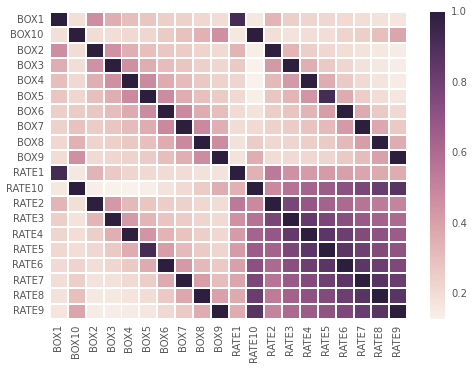

In [65]:
rate_col_list = [c for c in em2002.columns if c.startswith('RATE')]
box_rate_list = []
box_rate_list +=box_col_list
box_rate_list += rate_col_list
sns.heatmap(em2002[box_rate_list].corr())

Observation: the RATES are more closely correlated that the BOXES -- not that it matters if I only keep the recent values ('1')


### Keep just the most recent values so as to not bias it away from those who have been there longer.


In [66]:
# get just the most recent values
recentcols = [a for a in all_cols2 if a.endswith('1')]
len(recentcols)

19

In [67]:
## define the potential target columns
potential_target_cols = ['status','sep_status','retired','terminated']

# CREATE an evaluation Set
* use test_train_split
# Utilize Pipelines
* restrict the columns that I want to consider
* apply logic to 
    1. fill in missing values
    2. if numeric deal with outliers
    3. if categorical create dummy, factorize (label_encode), or survial_median

In [68]:
from sklearn import cross_validation
from sklearn.pipeline import Pipeline, FeatureUnion

In [69]:
# break into evaluation and build sets
print "Starting with subest of {0} employees.".format(len(em2002))
eval_fraction = 0.20
em2, em2eval = cross_validation.train_test_split(em2002,test_size=eval_fraction)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(em2eval),len(em2))

Starting with subest of 134236 employees.
Evaluation set has 26848 employees; training set has 107388 employees.


In [70]:
print "For retirement"
print em2.retired.value_counts()/len(em2)
print em2eval.retired.value_counts()/len(em2eval)
print "For Separation"
print em2.terminated.value_counts()/len(em2)
print em2eval.terminated.value_counts()/len(em2eval)


For retirement
0    0.887352
1    0.112648
dtype: float64
0    0.887515
1    0.112485
dtype: float64
For Separation
0    0.630769
1    0.369231
dtype: float64
0    0.627794
1    0.372206
dtype: float64


In [71]:
br.get_columns_with_nulls(em2[recentcols],rows_to_scan='all')

['PERF1', 'MERIT1', 'BOX1', 'ADDRCNT1']

In [357]:
X.ADDRCNT1.describe()

count    107369.000000
mean          0.088405
std           0.299934
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: ADDRCNT1, dtype: float64

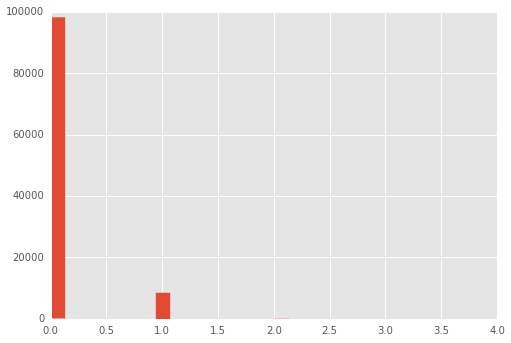

In [358]:
X.ADDRCNT1.hist(bins=30)

# some good indicator colums to keep:
* endswith "CNT"
* starts with 'HAVE'
* Male, HUBIND, FTE, DEP_COUNT,  INTERN, MAX_RT_ANNUAL, MIN_RT_ANNUAL,
* RELO_STATE_CNT_SFI

In [73]:
num_to_keep = [c for c in cols_numeric if c.endswith('CNT')]
num_to_keep.append('HAVE_INS')
num_to_keep.append('HAVE_DEP')
num_to_keep.append('INTERN')
num_to_keep.append('HUBIND')
num_to_keep.append('RELO_STATE_CNT_SFI')
num_to_keep.append('RELOCATE_ALL_SFI')
num_to_keep.append('STD_HOURS')
num_to_keep.append('unempl_rate')
num_to_keep.append('REMOTE')
num_to_keep.append('SUPV_DIFF_LOC')
num_to_keep.append('FTE')
num_to_keep.append('Male')
num_to_keep.append('SHIFT')
num_to_keep.append('FLSA_STATUS')
#num_to_keep.append('mar_status')
num_to_keep.append('REMOTE_SUPV')

num_to_keep.append('hourly_comp')
print len(num_to_keep)
salary_cols = ['MAX_RT_ANNUAL','MIN_RT_ANNUAL']


21


In [74]:
not_modeling_cols = list(set(cols_numeric) - set(recentcols) - set(cols_categorical2)-set(useful_time_cols)-set(potential_target_cols)-set(salary_cols) -set(num_to_keep))
print len(not_modeling_cols)
[c for c in not_modeling_cols]
#[c for c in set(cols_numeric) - set(recentcols) - set(other_categorical)-set(useful_time_cols)-set(potential_target_cols)]

98


['PERF10',
 'RATE9',
 'CUR_LOC_MOS',
 'PTFTCNT10',
 'FULLPART10',
 'FLOORCNT5',
 'FLOORCNT3',
 'FTPTCNT5',
 'JOBCNT10',
 'FTPTCNT3',
 'EFUNCCNT3',
 'CUR_EFUNC_MOS',
 'EFUNCCNT5',
 'MERIT10',
 'SUPVCNT5',
 'LOCSTCNT10',
 'SUPVCNT3',
 'PERF6',
 'PERF7',
 'PERF4',
 'PERF5',
 'PERF2',
 'PERF3',
 'SUPVCNT10',
 'PERF8',
 'PERF9',
 'PARTFULL5',
 'RATE6',
 'RATE5',
 'MERIT4',
 'RATE3',
 'RATE2',
 'PTFTCNT5',
 'PTFTCNT3',
 'BOX10',
 'LOCCNT3',
 'BOX9',
 'BOX8',
 'LOCCNT5',
 'BOX5',
 'BOX4',
 'BOX7',
 'RATE8',
 'BOX3',
 'BOX2',
 'CUR_JOB_MOS',
 'FUNCCNT5',
 'FUNCCNT3',
 'TOT_MO_SERVICE_SFI',
 'RATE10',
 'DEP_COUNT',
 'JOBCNT5',
 'JOBCNT3',
 'FUNCCNT10',
 'GRADECNT5',
 'GRADECNT3',
 'CUR_GRADE_MOS',
 'SAL8',
 'SAL9',
 'ANNUAL_RT',
 'SAL2',
 'SAL3',
 'SAL4',
 'SAL5',
 'SAL6',
 'SAL7',
 'SAL10',
 'RATE7',
 'EFUNCCNT10',
 'MERIT5',
 'RATE4',
 'MERIT3',
 'MERIT2',
 'PARTFULL3',
 'mar_status',
 'MERIT9',
 'MERIT8',
 'DEPTCNT10',
 'PARTFULL10',
 'TELE_MOS',
 'ADDRCNT3',
 'FLOORCNT10',
 'ADDRCNT5',
 'CU

In [75]:
len(num_to_keep), len(salary_cols), len(cols_categorical2), len(potential_target_cols),len(recentcols),len(useful_time_cols),len(cols_categorical)

(21, 2, 18, 4, 19, 3, 11)

In [76]:
num_to_keep

['TOTAL_RPT_CNT',
 'FUNC_CNT',
 'DIRECT_RPT_CNT',
 'EXTFUNC_CNT',
 'REH_CNT',
 'HAVE_INS',
 'HAVE_DEP',
 'INTERN',
 'HUBIND',
 'RELO_STATE_CNT_SFI',
 'RELOCATE_ALL_SFI',
 'STD_HOURS',
 'unempl_rate',
 'REMOTE',
 'SUPV_DIFF_LOC',
 'FTE',
 'Male',
 'SHIFT',
 'FLSA_STATUS',
 'REMOTE_SUPV',
 'hourly_comp']

## After all that I'm ready to process the subset of columns contained in these lists:
1. recentcols (19, numeric)
2. salary_cols (2, numeric)
3. useful_time_cols (3,numeric)
4. num_to_keep (21, numeric)
5. cols_categorical2 (18, categorical)
    * note I need to further refine/parse and eliminate some of these

####  Also I want to select from the potential_target_cols my 'y' variable
4 elements, numeric (0 or 1)

In [77]:
cols_to_model = []
cols_to_model += recentcols
cols_to_model += salary_cols
cols_to_model += useful_time_cols
cols_to_model += num_to_keep
print len(cols_to_model)

45


## Further refine the categorical ones:
* impute missing values for these

In [81]:
## Further refine the categorical ones:
print "column, arity, example, type"
[(c,len(em2[c].unique()),em2[c][0],em2[c].dtype) for c in cols_categorical2]

column, arity, example, type


[('JOB_FAMILY', 1385, 'ACLPRC', dtype('O')),
 ('LOC_TYPE_DESCR_SFI', 30, 'OPERATIONS CENTER', dtype('O')),
 ('EMPL_CLASS', 6, '1', dtype('O')),
 ('LOCATION', 10722, '20921', dtype('O')),
 ('EEO1CODE', 10, '5', dtype('O')),
 ('LOC_STATE', 51, 'CO', dtype('O')),
 ('LEGACY_DEPT_SFI', 26228, '120059921C9', dtype('O')),
 ('EMPL_TYPE', 5, 'E', dtype('O')),
 ('FULL_PART_TIME', 4, 'F', dtype('O')),
 ('JOB_FUNCTION', 19, 'PSA', dtype('O')),
 ('GRADE', 125, 'PA2', dtype('O')),
 ('FUNC_ID_SFI', 53, 14.0, dtype('float64')),
 ('EXT_FUNC_ID_SFI', 332, 125.0, dtype('float64')),
 ('FLOR_SFI', 109, 999, dtype('int64')),
 ('COMPANY', 6, 1, dtype('int64')),
 ('DIVISION_CODE_SFI', 9, 0.0, dtype('float64')),
 ('JOBCODE', 2447, 67, dtype('int64')),
 ('ETHNIC_GROUP', 8, 3.0, dtype('float64'))]

In [82]:
len(cols_categorical2)

18

In [231]:
cat_cols_to_survival = ['JOB_FAMILY','GRADE','JOB_FUNCTION','FLOR_SFI','FUNC_ID_SFI','EXT_FUNC_ID_SFI','JOBCODE']
                        
cat_cols_to_dummy_encode = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME','ETHNIC_GROUP','DIVISION_CODE_SFI','COMPANY']
cat_cols_to_label_encode = ['LOC_TYPE_DESCR_SFI','LOC_STATE']
cat_cols_to_drop = ['LEGACY_DEPT_SFI','LOCATION']

In [296]:
for c in cat_cols_to_drop:
    cols_categorical2.remove(c)
    #print c, len(em2[c].unique())

In [116]:
np.shape(em2)

(107388, 193)

In [142]:
from sklearn.pipeline import TransformerMixin
class ColumnExtractor(TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def transform(self, X, **transform_params):
        return X[self.columns]

    def fit(self, X, y=None, **fit_params):
        return self

In [156]:
from sklearn import preprocessing

In [297]:
my_cols = []
my_cols+=cols_to_model
my_cols+=cols_categorical2
print len(my_cols)

y = em2['terminated']
X = em2[my_cols]
print np.shape(X)
Xeval = em2eval[my_cols]
print np.shape(Xeval)

61
(107388, 61)
(26848, 61)


In [194]:
from sklearn.base import BaseEstimator

In [210]:
class LabelEncodeColumn(BaseEstimator, TransformerMixin):
    def __init__(self,columns_to_fix=[],rows_to_scan='all'):
        """
        A class that can be inserted into a pipeline
    
        This will replace a given list of columns with label_encoded values;
        
        Parameters
        ----------
        X: Pandas dataframe
        
        
        Note that new categories/values in test data will be set as -1.
        
        returns a pandas dataframe
        """
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        
    def fit(self, X, y=None):
        self.map_values = {}
        self.dummy_values = {}
        self.na_values={}
        
        rows_to_scan_in = br.get_rows_to_scan(self.rows_to_scan, X.shape[0])
        #self.columns_to_fix_in = br.get_list_of_columns_to_check(self.columns_to_fix, X.columns)
        X_temp = X[:rows_to_scan_in].copy()
        # apply labelEncoder to each column in this list
        for col in self.columns_to_fix:
            map_values = X_temp[col].unique()
            map_values.sort()
            self.map_values[col] = {key: index for index, key in enumerate(map_values)} 
        return self
    
    def transform(self, X, y=None):
        X_temp = X.copy()
        original_cols = list(X_temp.columns)
        for col in self.columns_to_fix:
            X_temp[str(col)+"_le"] = X_temp[col].map(self.map_values[col], "ignore")
            X_temp[str(col)+"_le"] =  X_temp[str(col)+"_le"].fillna(-1)
            # fill all remaining null values with -1
            # remove the original column name and add the new column name
            original_cols.remove(str(col))
            original_cols.append(str(col+"_le"))
        X_temp =X_temp[original_cols]
        
        return X_temp

In [219]:
class DummyEncodeColumn(BaseEstimator, TransformerMixin):
    def __init__(self,columns_to_fix=[],rows_to_scan='all',keep_dummies=False):
        """
        A class that can be inserted into a pipeline
    
        This will replace a given list of columns with label_encoded values;
        
        Parameters
        ----------
        X: Pandas dataframe
        
        keep_dummies: boolean (default = False)
            If False then the original dummied column and one of the one-hot-encoded (dummified) columns will be dropped.
            
        Note that new categories/values in test data will be set as -1.
        
        returns a pandas dataframe
        """
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        self.keep_dummies = keep_dummies
        
    def fit(self, X, y=None):
        #self.map_values = {}
        self.dummy_values = {}
        #self.na_values={}
        
        rows_to_scan_in = br.get_rows_to_scan(self.rows_to_scan, X.shape[0])
        #self.columns_to_fix_in = br.get_list_of_columns_to_check(self.columns_to_fix, X.columns)
        X_temp = X[:rows_to_scan_in].copy()
        # apply labelEncoder to each column in this list
        for col in self.columns_to_fix:
            self.dummy_values[col] = X_temp[col].unique()    
        return self
    
    def transform(self, X, y=None):
        X_temp = X.copy()
        original_cols = list(X_temp.columns)
        """
        for col in self.columns_to_fix:
            tmp = pd.get_dummies(X[col],prefix=str(col))
            X_temp = pd.concat([X_temp,tmp],axis=1)
            # now drop the columns that I don't want if so flagged
            if not self.keep_dummies:
                X_temp.drop([col,tmp.columns[-1]],axis=1,inplace=True)
         """  
        for col in self.columns_to_fix:            
            for cat in self.dummy_values[col]:
                cat_col = str(col)+'_'+str(cat)
                if str(cat) == 'nan':
                    X_temp[cat_col] = X_temp[col].isnull().astype(int)
                else:    
                    X_temp[cat_col] = (X_temp[col] == cat).astype(int)
                # append the new column name
                original_cols.append(cat_col)
            # if keep_dummies is false remove the original column name and the last category
            if not self.keep_dummies:
                original_cols.remove(str(col))
                original_cols.pop() #note pop removes the last element from a list
        X_temp =X_temp[original_cols]
        
        return X_temp

In [382]:
# function to replace missing by a given value
class FillMissingValue(BaseEstimator, TransformerMixin):
    def __init__(self,fill_value = 0,columns_to_fix='all',rows_to_scan='all',keep_dummies = False,fill_inf = True):
        """
        A class that can be inserted into a pipeline
    
        This will replace a given list of columns with label_encoded values;
        
        Parameters
        ----------
        X: Pandas dataframe
        
        
     
        
        returns a pandas dataframe
        """
        self.fill_value = fill_value
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        self.keep_dummies = keep_dummies
        self.fill_inf = fill_inf
        self.values = {}
        
    def fit(self, X, y=None):
        
        X_temp = X.copy()        
        if self.columns_to_fix == 'all':
            X_temp = X_temp.replace(np.inf, np.nan)
            self.columns_to_fix_in = br.get_numeric(X_temp)
        elif self.columns_to_fix == 'auto':
            X_temp = X_temp.replace(np.inf, np.nan)
            self.columns_to_fix_in = br.get_columns_with_nulls(X_temp, 'all', 'all')            
        else:
            self.columns_to_fix_in = br.get_list_of_columns_to_check(self.columns_to_fix, X.columns)
            self.columns_to_fix_in = [col for col in self.columns_to_fix_in if col in br.get_numeric(X_temp)]
            X_temp[self.columns_to_fix_in] = X_temp[self.columns_to_fix_in].replace(np.inf, np.nan)
        
        self.rows_to_scan_in = br.get_rows_to_scan(self.rows_to_scan, X.shape[0])
        
        # check if the fill_values are a list
        if type(self.fill_value)==list:
            self.values = dict(zip(self.columns_to_fix_in,self.fill_value))
        elif type(self.fill_value)==dict:
            self.values = self.fill_value
        else:
            for c in self.columns_to_fix_in:
                self.values[c]=self.fill_value
                
        return self
    
    def transform(self, X, y=None):
        X_temp = X.copy()
        
        if self.fill_inf:
            X_temp[self.columns_to_fix_in] = X_temp[self.columns_to_fix_in].replace(np.inf, np.nan)
        if self.keep_dummies:
            temp = pd.DataFrame(index=X_temp.index)
            for col in self.columns_to_fix_in:
                temp[(col+'_d')] = X_temp[col].isnull().astype("int")
            X_temp = pd.concat([X_temp, temp], axis=1) 
        original_cols = list(X_temp.columns)
        X_temp = X_temp.fillna(self.values)
        X_temp =X_temp[original_cols]
        
        return X_temp

In [215]:
pd.get_dummies(X[['FULL_PART_TIME','COMPANY']]).columns

Index([u'COMPANY', u'FULL_PART_TIME_F', u'FULL_PART_TIME_N',
       u'FULL_PART_TIME_P', u'FULL_PART_TIME_X'],
      dtype='object')

In [227]:
letest = LabelEncodeColumn(columns_to_fix=['GRADE','LOC_STATE','JOB_FAMILY','FUNC_ID_SFI'])
le_tmp = letest.fit(X,y).transform(testX)

In [229]:
le_tmp['FUNC_ID_SFI_le'].max(), testX['FUNC_ID_SFI'].max()

(51, 1800.0)

In [221]:
detest = DummyEncodeColumn(columns_to_fix=['EMPL_TYPE','FULL_PART_TIME','COMPANY'])
tmp = detest.fit(X,y).transform(testX)

In [225]:
[c for c in tmp.columns if c.startswith('EMPL_TYPE')]

['EMPL_TYPE_E', 'EMPL_TYPE_N', 'EMPL_TYPE_S', 'EMPL_TYPE_H']

In [226]:
X.EMPL_TYPE.value_counts()

E    68290
S    26229
H    11303
N     1557
X        9
dtype: int64

In [235]:
mthl_tenure_range = np.linspace(0,65,781)

In [260]:
def calculate_survival_functions_b(df,y, time_col, col_name,num_cutoff = 40,timerange =mthl_tenure_range):
    
    """ Function to generically return a dataframe of survival function, grouped by some categorical column
    inputs:
        df --> database to derive survival functions from
        time_col --> the temporal column to use for SF modeling (Kaplan Meier fitter applied)
        event_col --> the truncated column to use for SF modeling
        col_name --> the column to group up and determine KMF sf for
        num_cutoff --> number of groups to consider
        timerange --> min and max range
    outputs:
        survivalfunc_df --> a data frame that contains survival function.

    other options:
        *frac_cutoff --> the fraction of unique elements that will be kept as separate groups
        *min_size_cutoff --> min size to use for the cutoff.
        * these last two are not implemented
    """
    from lifelines import KaplanMeierFitter
    kmf=KaplanMeierFitter()
    # create example for all cases -- serves as background
    # create a time range
    
    kmf.fit(df[time_col],timeline=timerange,event_observed=y,label='all')
    survivalfunc_df = pd.DataFrame(kmf.survival_function_)
    # groupify the dataframe
    grp_value_counts = df[col_name].value_counts()
    #if frac_cutoff == None:
    #    #by default take 15 %
    #    frac_cutoff = .15 
    #top_n_groups = int(frac_cutoff *len(grp_value_counts))
    #if min_size_cutoff == None:
        # by default 
    # Take the top num_cutoff groups
    #my_grps = grp_value_counts.ix[:num_cutoff].index.tolist() 
    my_grps = grp_value_counts.iloc[:num_cutoff].index.tolist() 
    
    # make a list of elements in each of these groups
    grp_dict = {}
    for grp in my_grps: 
        grp_dict[grp] = df[df[col_name] == grp].index.tolist()
    # loop through grps and create kmf survival function
    for i,jgrp in enumerate(my_grps):
        j_idx = grp_dict[jgrp]
        #print i, jgrp, len(j_idx)
        kmf.fit(df[time_col].ix[j_idx],timeline=mthl_tenure_range,event_observed=y.ix[j_idx],label=str(jgrp))
        survivalfunc_df = pd.concat([survivalfunc_df,kmf.survival_function_],axis=1)
    
    
    return survivalfunc_df

In [237]:
def return_first_time_survival(sfdf,thresh=0.5):
    from collections import defaultdict
    
    # assign all value to the default
    default_value = sfdf[sfdf['all']<=thresh].index[0]
    median_survival_dict = defaultdict(lambda: default_value)
    for c in sfdf.columns[1:]:
        #print c
        try:
            my_sf_date = sfdf[sfdf[c]<=thresh].index[0]
        except IndexError: # because never reached that threshold value
            my_sf_date = sfdf.index[-1]
        except KeyError: # because of type of the key
            my_sf_date = sfdf[sfdf[int(c)]<=thresh].index[0]

        median_survival_dict[c]=my_sf_date
        
    return median_survival_dict

In [282]:
class SurvivalEncodeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_fix=[],rows_to_scan='all',method='median',max_number_groups=40, my_thresh=0.5):
        self.method = method
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        self.max_num_groups = max_number_groups
        self.thresh = my_thresh
        
    def fit(self,X,y):
        self.survive_columns = {} # dictionary to map old columns to new
        self.survive_values = {}
        self.column_cutoff = {}
        
        
        for col in self.columns_to_fix:
            #(assumes these have previously been label encoded so the values should be ints)"
            ncol=str(col)+"_le"
            num_cutoff = self.max_num_groups
            survive_col = 'surv_'+ncol.lower()
            nuniq = len(X[ncol].unique())
            if nuniq < num_cutoff:
                num_cutoff = nuniq
                
            self.column_cutoff[col]=num_cutoff
            
            #frac_accounted_for = X[col].value_counts().iloc[:num_cutoff].sum()/float(len(X))
            #print i,col,newcol, nuniq, num_cutoff,num_cutoff/float(nuniq),frac_accounted_for
            # I want to make this fraction close to 80%?
            sf_df = calculate_survival_functions_b(X,y,'Tenure_years', ncol,num_cutoff)
            self.survive_columns[col]=survive_col
            ## create the dictionary
            self.survive_values[col]=return_first_time_survival(sf_df,thresh=self.thresh)
    
        return self
    def transform(self,X,y=None):
        X_temp = X.copy()
        original_cols = list(X_temp.columns)
        for col in self.columns_to_fix:
            ncol=str(col)+"_le" # assumes labelencoded
            new_col = self.survive_columns[col]
            col_dict = self.survive_values[col]
            X_temp[new_col] = X_temp[ncol].apply(lambda x: col_dict[str(x)])
            original_cols.remove(ncol)
            original_cols.append(new_col)
        
        X_temp = X_temp[original_cols]
        return X_temp
    

In [261]:
gsfdf = calculate_survival_functions_b(leX,y,'Tenure_years','GRADE_le',40)
gsfdf.shape

(781, 41)

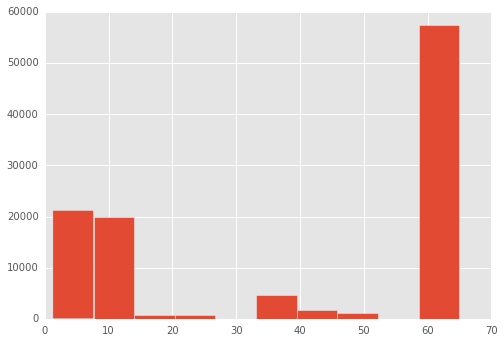

In [268]:
leX.GRADE_le.apply(lambda x: a[str(x)]).hist()

In [233]:
# combine cat_cols_label_encode and cat_cols_surv_encode
my_label_encode_cols = []
my_label_encode_cols+=cat_cols_to_survival
my_label_encode_cols+=cat_cols_to_label_encode
print len(my_label_encode_cols)
my_label_encode_cols

9


['JOB_FAMILY',
 'GRADE',
 'JOB_FUNCTION',
 'FLOR_SFI',
 'FUNC_ID_SFI',
 'EXT_FUNC_ID_SFI',
 'JOBCODE',
 'LOC_TYPE_DESCR_SFI',
 'LOC_STATE']

In [383]:

#cate_list = br.get_categorical(X)
# need to break the categorical into types
pipe = Pipeline([("null", br.RemoveAllNull()),  
                 ("label_encode",LabelEncodeColumn(my_label_encode_cols)),
                 ("dummy_encode", DummyEncodeColumn(cat_cols_to_dummy_encode)),
                 ("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 #("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],criteria_coef=('percentile',5),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',5),
                                                   method='both',fill_with='nearest_value')),
                 ("fill_missingzero",FillMissingValue(columns_to_fix=['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT'],fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=['MERIT1','PERF1','ADDRCNT1'],rows_to_scan=0.8)),
                 ("imp_mean", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.8))])
                 #("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])
#pipe.fit(X, y).transform(testX)[0:30]
#
#Xft = pipe.fit_transform(X)

### Aside --> check on missing value columns

In [373]:
missing_column_list = br.get_columns_with_nulls(X)
for c in missing_column_list:
    print c,sum(X[c].isnull()),X[c].mode()

PERF1 11980 0    0
dtype: float64
MERIT1 11980 0    0
dtype: float64
BOX1 20217 0    2
dtype: float64
ADDRCNT1 19 0    0
dtype: float64
TOTAL_RPT_CNT 1586 0    12
dtype: float64
FUNC_CNT 4 0    34937
dtype: float64
DIRECT_RPT_CNT 1586 0    10
dtype: float64
EXTFUNC_CNT 43 0    6133
dtype: float64


In [371]:
X[['FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT']].describe()

,FUNC_CNT,EXTFUNC_CNT,TOTAL_RPT_CNT,DIRECT_RPT_CNT
count,107384.000000,107345.000000,105802.000000,105802.000000
mean,17573.859793,2458.598873,34.491371,12.893452
std,15049.400314,3158.768228,424.201462,10.244684
min,1.000000,1.000000,1.000000,1.000000
25%,3163.000000,458.000000,9.000000,8.000000
50%,7769.000000,1196.000000,12.000000,11.000000
75%,34937.000000,2794.000000,17.000000,15.000000
max,37341.000000,17761.000000,71331.000000,318.000000


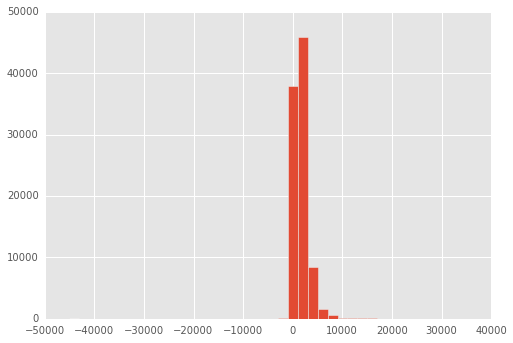

In [318]:
X.MERIT1.hist(bins=40)

In [353]:
X.MERIT1.describe()

count    95408.000000
mean      1485.597972
std       1981.777000
min     -45000.000000
25%        481.250000
50%       1282.835000
75%       2132.150000
max      35000.000000
Name: MERIT1, dtype: float64

In [356]:
X[X.MERIT1<0].MERIT1.describe()

count      433.000000
mean    -12233.868719
std      10618.251958
min     -45000.000000
25%     -17334.100000
50%     -11750.000000
75%      -2864.420000
max         -0.002357
Name: MERIT1, dtype: float64

In [368]:
#br.FixNumericOutlier(columns_to_fix=['MERIT1'],criteria_coef=('percentile',5),
#                                                   method='lower',fill_with='nearest_value')
fixout=br.FixNumericOutlier(columns_to_fix=['MERIT1','PERF1'], criteria_coef=('percentile', 5), 
                            method = 'lower', fill_with='nearest_value')
                            
X1 = fixout.fit(X).transform(X)
print X1[['MERIT1','PERF1']].describe()

             MERIT1         PERF1
count  95408.000000  95408.000000
mean    1541.120204   1855.572259
std     1603.001281   1818.740447
min        0.000000      0.000000
25%      481.250000    472.500000
50%     1282.835000   1444.420000
75%     2132.150000   2791.732500
max    35000.000000  56751.140000


In [366]:
X1.MERIT1.mode()

0    0
dtype: float64

In [324]:
time_stamp_cols

['birth_tstmp', 'hire_tstmp', 'term_tstmp']

In [326]:
em2.ix[X['ADDRCNT1'].isnull().index][['Age_years','hire_tstmp','term_tstmp']]

,Age_years,hire_tstmp,term_tstmp
49367,59.472816,1974-02-20,2006-03-31
86464,32.055415,1995-11-06,2002-05-31
40829,51.719063,1988-08-08,2015-01-01
85328,57.542592,1980-01-28,2004-04-30
36315,41.454650,1997-12-01,2015-01-01
118281,53.605481,1985-01-28,2015-01-01
45455,40.009035,2014-06-23,2015-01-01
50901,24.871147,2012-01-16,2012-07-27
65887,62.194296,1988-01-04,2015-01-01
15894,63.587890,1975-12-15,2010-05-31


In [ ]:
kfold

#OKAY So NEXT Step is to apply the transformation using my pipe and check for collinearity

In [395]:
tXeval = pipe.fit(X,y).transform(Xeval)

In [384]:
Xft = pipe.fit_transform(X,y)

In [392]:
[c for c in Xft.columns if 'BOX' in c]

['BOX1']

In [386]:
br.perfect_collinearity_test(Xft)

FLOORCNT1             VIF = 2.5   R^2 = 0.5951    
FULLPART1             VIF = 409.2 R^2 = 0.9976    
EFUNCCNT1             VIF = 3.9   R^2 = 0.7466    
PERF1                 VIF = 7.1   R^2 = 0.86      
PTFTCNT1              VIF = 1150.4R^2 = 0.9991    
MERIT1                VIF = 5.3   R^2 = 0.8126    
LOCCNT1               VIF = 2.4   R^2 = 0.5816    
BOX1                  VIF = 231.7 R^2 = 0.9957    
FUNCCNT1              VIF = 4.1   R^2 = 0.7569    
SUPVCNT1              VIF = 2.0   R^2 = 0.4931    
JOBCNT1               VIF = 4.0   R^2 = 0.7486    
GRADECNT1             VIF = 2.8   R^2 = 0.6413    
SAL1                  VIF = 16.0  R^2 = 0.9374    
PARTFULL1             VIF = 1149.8R^2 = 0.9991    
RATE1                 VIF = 198.3 R^2 = 0.995     
ADDRCNT1              VIF = 3.3   R^2 = 0.6995    
FTPTCNT1              VIF = 409.1 R^2 = 0.9976    
LOCSTCNT1             VIF = 3.8   R^2 = 0.7342    
DEPTCNT1              VIF = 4.0   R^2 = 0.7516    
MAX_RT_ANNUAL         VIF = 65.

FLOORCNT1                0.595144
FULLPART1                0.997557
EFUNCCNT1                0.746568
PERF1                    0.859969
PTFTCNT1                 0.999131
MERIT1                   0.812596
LOCCNT1                  0.581566
BOX1                     0.995683
FUNCCNT1                 0.756860
SUPVCNT1                 0.493146
JOBCNT1                  0.748644
GRADECNT1                0.641294
SAL1                     0.937439
PARTFULL1                0.999130
RATE1                    0.994958
ADDRCNT1                 0.699503
FTPTCNT1                 0.997556
LOCSTCNT1                0.734239
DEPTCNT1                 0.751614
MAX_RT_ANNUAL            0.984710
MIN_RT_ANNUAL            0.981224
Tenure_years             1.000000
Age_years                1.000000
hire_age                 1.000000
TOTAL_RPT_CNT            0.551878
FUNC_CNT                 0.815663
DIRECT_RPT_CNT           0.477043
EXTFUNC_CNT              0.814689
REH_CNT                  0.486677
HAVE_INS      

,Percentage


,FLOORCNT1,FULLPART1,EFUNCCNT1,PERF1,PTFTCNT1,MERIT1,LOCCNT1,BOX1,FUNCCNT1,SUPVCNT1,JOBCNT1,GRADECNT1,SAL1,PARTFULL1,RATE1,ADDRCNT1,FTPTCNT1,LOCSTCNT1,DEPTCNT1,MAX_RT_ANNUAL,MIN_RT_ANNUAL,Tenure_years,Age_years,hire_age,TOTAL_RPT_CNT,FUNC_CNT,DIRECT_RPT_CNT,EXTFUNC_CNT,REH_CNT,HAVE_INS,HAVE_DEP,INTERN,HUBIND,RELO_STATE_CNT_SFI,RELOCATE_ALL_SFI,STD_HOURS,unempl_rate,REMOTE,SUPV_DIFF_LOC,FTE,Male,SHIFT,FLSA_STATUS,REMOTE_SUPV,hourly_comp,EXT_FUNC_ID_SFI_le,JOBCODE_le,LOC_TYPE_DESCR_SFI_le,LOC_STATE_le,EMPL_CLASS_1,EMPL_CLASS_D,EMPL_CLASS_3,EMPL_CLASS_4,EMPL_CLASS_5,EEO1CODE_3,EEO1CODE_4,EEO1CODE_2,EEO1CODE_5,EEO1CODE_1,EEO1CODE_6,EEO1CODE_7,EEO1CODE_8,EEO1CODE_N,EMPL_TYPE_E,EMPL_TYPE_N,EMPL_TYPE_S,EMPL_TYPE_H,FULL_PART_TIME_F,FULL_PART_TIME_X,FULL_PART_TIME_P,ETHNIC_GROUP_1.0,ETHNIC_GROUP_2.0,ETHNIC_GROUP_3.0,ETHNIC_GROUP_8.0,ETHNIC_GROUP_4.0,ETHNIC_GROUP_5.0,ETHNIC_GROUP_7.0,DIVISION_CODE_SFI_6.0,DIVISION_CODE_SFI_9.0,DIVISION_CODE_SFI_0.0,DIVISION_CODE_SFI_2.0,DIVISION_CODE_SFI_4.0,DIVISION_CODE_SFI_1.0,DIVISION_CODE_SFI_3.0,DIVISION_CODE_SFI_5.0,COMPANY_1,COMPANY_5,COMPANY_49,COMPANY_2,COMPANY_4,surv_job_family_le,surv_grade_le,surv_job_function_le,surv_flor_sfi_le,surv_func_id_sfi_le,MERIT1_d,PERF1_d,ADDRCNT1_d
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.039700,0.003700,0.224100,1831.550458,0.009200,1546.591643,0.143500,1.705100,0.102300,0.747700,0.203100,0.132400,54853.008591,0.009200,1.686500,0.085118,0.003700,0.023800,0.427100,68455.853960,40058.588737,13.092968,42.469773,29.376806,36.704100,17445.409300,12.70890,2467.169800,0.163400,0.599900,0.352900,0.069800,0.360700,9.450800,0.148400,37.679913,6.012080,0.083700,0.247800,0.970953,0.375300,0.999300,0.224900,0.034500,0.073200,116.212300,687.395000,14.004600,21.879900,0.978300,0.016500,0.004700,0.000500,0,0.016800,0.038200,0.414000,0.443000,0.081400,0.003400,0.003200,0,0,0.639100,0.016500,0.241200,0.103000,0.906600,0.017000,0.068400,0.7091,0.158700,0.085500,0.017100,0.022700,0.004700,0.002000,0.027200,0.60390,0.18670,0.042900,0.036000,0.039100,0.028900,0.031700,0.859200,0.137300,0.002200,0.001300,0,30.343675,40.271292,34.906767,31.236375,39.623325,0.110700,0.110700,0.000200
std,0.223895,0.060718,0.468723,1639.548536,0.095479,1498.639434,0.417762,0.934142,0.319758,1.040458,0.444376,0.360671,30896.822688,0.095479,0.948107,0.294050,0.060718,0.155679,0.730574,29562.676815,19034.503157,11.698111,12.547486,9.267099,723.136293,15054.920049,10.61091,3226.911467,0.563677,0.489943,0.477896,0.254822,0.480228,19.040321,0.355514,4.117779,1.112505,0.276951,0.431757,0.112764,0.484224,0.196223,0.455566,0.182519,0.260478,108.121473,712.892706,5.777691,14.662134,0.145709,0.127395,0.068399,0.022356,0,0.128528,0.191688,0.492573,0.496765,0.273462,0.058213,0.056481,0,0,0.480286,0.127395,0.427833,0.303974,0.2

,Counts
0,6207
1,3793


,corr,p-value
HAVE_INS,-0.604683,0.000000e+00
Age_years,-0.441067,0.000000e+00
Tenure_years,-0.440692,0.000000e+00
HAVE_DEP,-0.425907,0.000000e+00
surv_grade_le,-0.424680,0.000000e+00
PERF1,-0.422494,0.000000e+00
MIN_RT_ANNUAL,-0.393025,0.000000e+00
SAL1,-0.388146,0.000000e+00
BOX1,-0.387094,0.000000e+00
RATE1,-0.370403,8.893182e-323


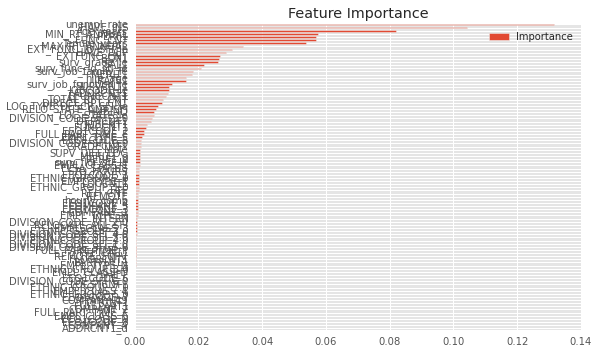

,Percentage


['surv_job_family_le']


[]


['EMPL_CLASS_5', 'EEO1CODE_8', 'EEO1CODE_N', 'COMPANY_4']


['FULLPART1', 'PTFTCNT1', 'PARTFULL1', 'FTPTCNT1', 'Tenure_years', 'Age_years', 'hire_age', 'EMPL_CLASS_1', 'EMPL_CLASS_D', 'EMPL_CLASS_3', 'EMPL_CLASS_4', 'EMPL_CLASS_5', 'EEO1CODE_3', 'EEO1CODE_4', 'EEO1CODE_2', 'EEO1CODE_5', 'EEO1CODE_1', 'EEO1CODE_6', 'EEO1CODE_7', 'EEO1CODE_8', 'EEO1CODE_N', 'COMPANY_1', 'COMPANY_5', 'COMPANY_49', 'COMPANY_2', 'COMPANY_4', 'MERIT1_d', 'PERF1_d']


[]


[]


[]


,Importance
unempl_rate,0.131582
HAVE_INS,0.104148
Age_years,0.082060
MIN_RT_ANNUAL,0.057554
PERF1,0.057009
FUNC_CNT,0.056787
Tenure_years,0.053806
MAX_RT_ANNUAL,0.033995
EXT_FUNC_ID_SFI_le,0.030618
HAVE_DEP,0.028555


In [396]:
br.get_initial_analysis(Xft, y, tXeval, rows_to_scan=10000, sample_size=5000, random_state=42, cate_cap=10)

# August 17, 2015
#### At this point I have a pipeline to process the input (and eval) data.

#### here is what it does:
1. labelEncodes the string variables (categorical) that I don't want to get dumped
2. applies a dummy encoding to OneHotEncode categorical varables with less than 18 categories
3. applies a survival function to subset of categorical that I want to do this too
4. 'fixes outliers' in salary related data: SAL1, MIN_RT_ANNUAL MAX_RT_ANNUAL, PERF1,MERIT1
5. imputes missing:
    * BOX1, FUNC_CNT, EXTFUNC_CNT, TOTAL_RPT_CNT, DIRECT_RPT_CNT set to zero
    * PERF1, MERIT1, ADDRCNT1 set to mode (which is zero)
    * others set to mean

In [391]:
Xft.BOX1.value_counts(), Xft.MERIT1.describe()

(2    65360
 0    20217
 3    15239
 1     6572
 dtype: int64, count    107388.000000
 mean       1541.517106
 std        1510.943601
 min           0.000000
 25%         609.792500
 50%        1460.130000
 75%        1989.525000
 max       35000.000000
 Name: MERIT1, dtype: float64)

## Aug 21, 2015
* I want to drop hire_age (collinear)
* 

In [398]:
Xft[['PERF1','MERIT1','hire_age','Age_years','Tenure_years']].corr()

,PERF1,MERIT1,hire_age,Age_years,Tenure_years
PERF1,1.000000,0.322337,-0.075027,0.347824,0.431138
MERIT1,0.322337,1.000000,-0.069675,-0.050974,-0.000886
hire_age,-0.075027,-0.069675,1.000000,0.451126,-0.288211
Age_years,0.347824,-0.050974,0.451126,1.000000,0.724571
Tenure_years,0.431138,-0.000886,-0.288211,0.724571,1.000000


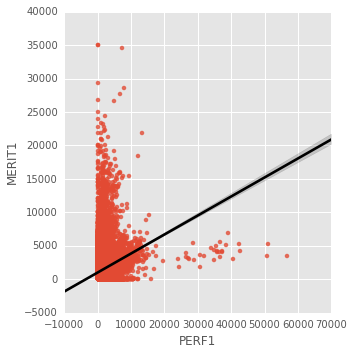

In [402]:
sns.lmplot(x='PERF1',y='MERIT1',data=Xft,line_kws={'color':'k'})

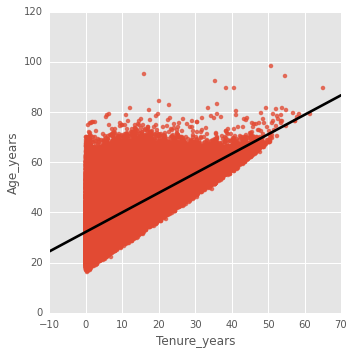

In [403]:
sns.lmplot(x='Tenure_years',y='Age_years',data=Xft,line_kws={'color':'k'})

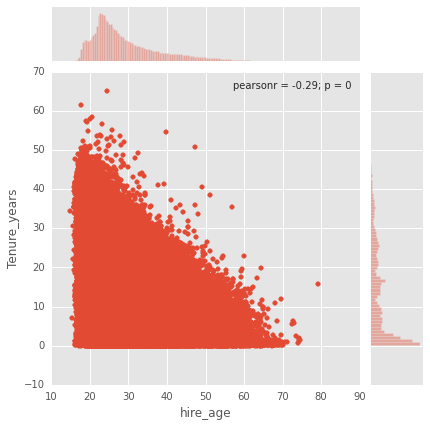

In [405]:
sns.jointplot(x='hire_age',y='Tenure_years',data=Xft)

In [407]:
minimum_cols = ['Tenure_years','Age_years','MAX_RT_ANNUAL','MIN_RT_ANNUAL','SAL1','HAVE_INS','HAVE_DEP','Male','EMPL_TYPE']

# need to redefine my pipe

In [441]:
#class to drop a list of columns
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self,columns_to_drop=[]):
        """
        A class that can be inserted into a pipeline
    
        This will drop columns that are listed as input to this class
        
        Parameters
        ----------
        X: Pandas dataframe
        
        
        columns_to_drop: a list of columns to remove from the input DF.
        
        returns a pandas dataframe
        """
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        self.columns_to_drop = self.columns_to_drop
        return self
        
    
    def transform(self, X, y=None):
        X_temp = X.copy()
        for col in X_temp.columns:
            if col in self.columns_to_drop:
                X_temp.pop(col)
        
        return X_temp

In [428]:
X.columns

Index([u'FLOORCNT1', u'FULLPART1', u'EFUNCCNT1', u'PERF1', u'PTFTCNT1',
       u'MERIT1', u'LOCCNT1', u'BOX1', u'FUNCCNT1', u'SUPVCNT1', u'JOBCNT1',
       u'GRADECNT1', u'SAL1', u'PARTFULL1', u'RATE1', u'ADDRCNT1', u'FTPTCNT1',
       u'LOCSTCNT1', u'DEPTCNT1', u'MAX_RT_ANNUAL', u'MIN_RT_ANNUAL',
       u'Tenure_years', u'Age_years', u'hire_age', u'TOTAL_RPT_CNT',
       u'FUNC_CNT', u'DIRECT_RPT_CNT', u'EXTFUNC_CNT', u'REH_CNT', u'HAVE_INS',
       u'HAVE_DEP', u'INTERN', u'HUBIND', u'RELO_STATE_CNT_SFI',
       u'RELOCATE_ALL_SFI', u'STD_HOURS', u'unempl_rate', u'REMOTE',
       u'SUPV_DIFF_LOC', u'FTE', u'Male', u'SHIFT', u'FLSA_STATUS',
       u'REMOTE_SUPV', u'hourly_comp', u'JOB_FAMILY', u'LOC_TYPE_DESCR_SFI',
       u'EMPL_CLASS', u'EEO1CODE', u'LOC_STATE', u'EMPL_TYPE',
       u'FULL_PART_TIME', u'JOB_FUNCTION', u'GRADE', u'FUNC_ID_SFI',
       u'EXT_FUNC_ID_SFI', u'FLOR_SFI', u'COMPANY', u'DIVISION_CODE_SFI',
       u'JOBCODE', u'ETHNIC_GROUP'],
      dtype='object')

In [418]:
set_minimum_cols= set(minimum_cols)
my_minfix_cols = ['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1']
my_maxfix_cols = ['MAX_RT_ANNUAL']
missing_zero_cols = ['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT']
mode_impute_cols = ['MERIT1','PERF1','ADDRCNT1']
mean_impute_cols = 'auto'



In [442]:
pipe2 = Pipeline([("null",br.RemoveAllNull()),
                 ("drop",DropColumns(columns_to_drop =['hire_age','unempl_rate'])),  
                 ("label_encode",LabelEncodeColumn(my_label_encode_cols)),
                 ("dummy_encode", DummyEncodeColumn(cat_cols_to_dummy_encode)),
                 ("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),                 
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=my_minfix_cols,criteria_coef=('percentile',5),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_ANNUAL_RT'],criteria_coef=('percentile',5),
                                                   method='both',fill_with='nearest_value')),
                 ("fill_missingzero",FillMissingValue(columns_to_fix=missing_zero_cols,fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=mode_impute_cols,rows_to_scan=0.8))])
                 #("imp_mean", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.8))])

In [443]:
Xft_mincols = pipe2.fit_transform(X,y)

In [445]:
np.shape(Xft_mincols), np.shape(Xft)

((107388, 96), (107388, 98))

In [446]:
tXeval_mincols = pipe2.fit(X,y).transform(Xeval)

In [447]:
br.perfect_collinearity_test(Xft_mincols)

FLOORCNT1             VIF = 2.5   R^2 = 0.5921    
FULLPART1             VIF = 399.3 R^2 = 0.9975    
EFUNCCNT1             VIF = 4.0   R^2 = 0.7485    
PERF1                 VIF = 7.2   R^2 = 0.8604    
PTFTCNT1              VIF = 1150.3R^2 = 0.9991    
MERIT1                VIF = 5.2   R^2 = 0.8068    
LOCCNT1               VIF = 2.4   R^2 = 0.5878    
BOX1                  VIF = 209.5 R^2 = 0.9952    
FUNCCNT1              VIF = 4.0   R^2 = 0.7487    
SUPVCNT1              VIF = 2.0   R^2 = 0.4913    
JOBCNT1               VIF = 3.8   R^2 = 0.7336    
GRADECNT1             VIF = 2.9   R^2 = 0.6495    
SAL1                  VIF = 17.6  R^2 = 0.9432    
PARTFULL1             VIF = 1149.7R^2 = 0.9991    
RATE1                 VIF = 177.0 R^2 = 0.9944    
ADDRCNT1              VIF = 3.3   R^2 = 0.6954    
FTPTCNT1              VIF = 399.2 R^2 = 0.9975    
LOCSTCNT1             VIF = 3.8   R^2 = 0.7347    
DEPTCNT1              VIF = 3.9   R^2 = 0.7424    
MAX_RT_ANNUAL         VIF = 86.

FLOORCNT1                0.592148
FULLPART1                0.997495
EFUNCCNT1                0.748476
PERF1                    0.860433
PTFTCNT1                 0.999131
MERIT1                   0.806810
LOCCNT1                  0.587798
BOX1                     0.995227
FUNCCNT1                 0.748719
SUPVCNT1                 0.491276
JOBCNT1                  0.733566
GRADECNT1                0.649526
SAL1                     0.943184
PARTFULL1                0.999130
RATE1                    0.994351
ADDRCNT1                 0.695397
FTPTCNT1                 0.997495
LOCSTCNT1                0.734654
DEPTCNT1                 0.742430
MAX_RT_ANNUAL            0.988442
MIN_RT_ANNUAL            0.990442
Tenure_years             0.813943
Age_years                0.695630
TOTAL_RPT_CNT            0.570147
FUNC_CNT                 0.809419
DIRECT_RPT_CNT           0.477770
EXTFUNC_CNT              0.817601
REH_CNT                  0.481764
HAVE_INS                 0.600681
HAVE_DEP      

,Percentage


,FLOORCNT1,FULLPART1,EFUNCCNT1,PERF1,PTFTCNT1,MERIT1,LOCCNT1,BOX1,FUNCCNT1,SUPVCNT1,JOBCNT1,GRADECNT1,SAL1,PARTFULL1,RATE1,ADDRCNT1,FTPTCNT1,LOCSTCNT1,DEPTCNT1,MAX_RT_ANNUAL,MIN_RT_ANNUAL,Tenure_years,Age_years,TOTAL_RPT_CNT,FUNC_CNT,DIRECT_RPT_CNT,EXTFUNC_CNT,REH_CNT,HAVE_INS,HAVE_DEP,INTERN,HUBIND,RELO_STATE_CNT_SFI,RELOCATE_ALL_SFI,STD_HOURS,REMOTE,SUPV_DIFF_LOC,FTE,Male,SHIFT,FLSA_STATUS,REMOTE_SUPV,hourly_comp,EXT_FUNC_ID_SFI_le,JOBCODE_le,LOC_TYPE_DESCR_SFI_le,LOC_STATE_le,EMPL_CLASS_1,EMPL_CLASS_D,EMPL_CLASS_3,EMPL_CLASS_4,EMPL_CLASS_5,EEO1CODE_3,EEO1CODE_4,EEO1CODE_2,EEO1CODE_5,EEO1CODE_1,EEO1CODE_6,EEO1CODE_7,EEO1CODE_8,EEO1CODE_N,EMPL_TYPE_E,EMPL_TYPE_N,EMPL_TYPE_S,EMPL_TYPE_H,FULL_PART_TIME_F,FULL_PART_TIME_X,FULL_PART_TIME_P,ETHNIC_GROUP_1.0,ETHNIC_GROUP_2.0,ETHNIC_GROUP_3.0,ETHNIC_GROUP_8.0,ETHNIC_GROUP_4.0,ETHNIC_GROUP_5.0,ETHNIC_GROUP_7.0,DIVISION_CODE_SFI_6.0,DIVISION_CODE_SFI_9.0,DIVISION_CODE_SFI_0.0,DIVISION_CODE_SFI_2.0,DIVISION_CODE_SFI_4.0,DIVISION_CODE_SFI_1.0,DIVISION_CODE_SFI_3.0,DIVISION_CODE_SFI_5.0,COMPANY_1,COMPANY_5,COMPANY_49,COMPANY_2,COMPANY_4,surv_job_family_le,surv_grade_le,surv_job_function_le,surv_flor_sfi_le,surv_func_id_sfi_le,MERIT1_d,PERF1_d,ADDRCNT1_d
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.039700,0.003700,0.224100,1831.550458,0.009200,1546.591643,0.143500,1.705100,0.102300,0.747700,0.203100,0.132400,54853.008591,0.009200,1.686500,0.085118,0.003700,0.023800,0.427100,69046.677146,40058.588737,13.092968,42.469773,36.704100,17445.409300,12.70890,2467.169800,0.163400,0.599900,0.352900,0.069800,0.360700,9.450800,0.148400,37.679913,0.083700,0.247800,0.970953,0.375300,0.999300,0.224900,0.034500,0.073200,116.212300,687.395000,14.004600,21.879900,0.978300,0.016500,0.004700,0.000500,0,0.016800,0.038200,0.414000,0.443000,0.081400,0.003400,0.003200,0,0,0.639100,0.016500,0.241200,0.103000,0.906600,0.017000,0.068400,0.7091,0.158700,0.085500,0.017100,0.022700,0.004700,0.002000,0.027200,0.60390,0.18670,0.042900,0.036000,0.039100,0.028900,0.031700,0.859200,0.137300,0.002200,0.001300,0,30.343675,40.271292,34.906767,31.236375,39.623325,0.110700,0.110700,0.000200
std,0.223895,0.060718,0.468723,1639.548536,0.095479,1498.639434,0.417762,0.934142,0.319758,1.040458,0.444376,0.360671,30896.822688,0.095479,0.948107,0.294050,0.060718,0.155679,0.730574,39236.627606,19034.503157,11.698111,12.547486,723.136293,15054.920049,10.61091,3226.911467,0.563677,0.489943,0.477896,0.254822,0.480228,19.040321,0.355514,4.117779,0.276951,0.431757,0.112764,0.484224,0.196223,0.455566,0.182519,0.260478,108.121473,712.892706,5.777691,14.662134,0.145709,0.127395,0.068399,0.022356,0,0.128528,0.191688,0.492573,0.496765,0.273462,0.058213,0.056481,0,0,0.480286,0.127395,0.427833,0.303974,0.291007,0.129277,0.252444,0.4542,0.365414,0.279638,0.129651,0.148953,0.068399,0.044679

,Counts
0,6207
1,3793


,corr,p-value
HAVE_INS,-0.604683,0.000000e+00
Age_years,-0.441067,0.000000e+00
Tenure_years,-0.440692,0.000000e+00
HAVE_DEP,-0.425907,0.000000e+00
surv_grade_le,-0.424680,0.000000e+00
PERF1,-0.422494,0.000000e+00
MIN_RT_ANNUAL,-0.393025,0.000000e+00
SAL1,-0.388146,0.000000e+00
BOX1,-0.387094,0.000000e+00
RATE1,-0.370403,8.893182e-323


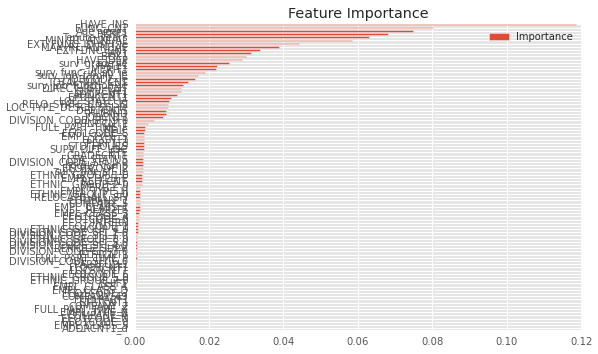

,Percentage


['surv_job_family_le']


[]


['EMPL_CLASS_5', 'EEO1CODE_8', 'EEO1CODE_N', 'COMPANY_4']


['FULLPART1', 'PTFTCNT1', 'PARTFULL1', 'FTPTCNT1', 'EMPL_CLASS_1', 'EMPL_CLASS_D', 'EMPL_CLASS_3', 'EMPL_CLASS_4', 'EMPL_CLASS_5', 'EEO1CODE_3', 'EEO1CODE_4', 'EEO1CODE_2', 'EEO1CODE_5', 'EEO1CODE_1', 'EEO1CODE_6', 'EEO1CODE_7', 'EEO1CODE_8', 'EEO1CODE_N', 'COMPANY_1', 'COMPANY_5', 'COMPANY_49', 'COMPANY_2', 'COMPANY_4', 'MERIT1_d', 'PERF1_d']


[]


[]


[]


,Importance
HAVE_INS,0.118581
FUNC_CNT,0.080328
Age_years,0.074920
PERF1,0.068262
Tenure_years,0.063081
MIN_RT_ANNUAL,0.058396
EXT_FUNC_ID_SFI_le,0.044202
MAX_RT_ANNUAL,0.038865
EXTFUNC_CNT,0.033692
SAL1,0.031311


In [448]:
br.get_initial_analysis(Xft_mincols, y, tXeval_mincols, rows_to_scan=10000, sample_size=5000, random_state=42, cate_cap=10)

In [449]:
minimum_cols

['Tenure_years',
 'Age_years',
 'MAX_RT_ANNUAL',
 'MIN_RT_ANNUAL',
 'SAL1',
 'HAVE_INS',
 'HAVE_DEP',
 'Male',
 'EMPL_TYPE']

##Try again using just a very small set of columns

,Percentage


,Tenure_years,Age_years,MAX_RT_ANNUAL,MIN_RT_ANNUAL,SAL1,HAVE_INS,HAVE_DEP,Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,13.166546,42.491776,69864.911371,39985.908846,54899.123108,0.593200,0.342800,0.376500
std,11.864066,12.696861,39295.603942,19930.957231,32614.212047,0.491262,0.474669,0.484532
min,0.000000,16.252216,0.000000,0.000000,6567.600000,0.000000,0.000000,0.000000
25%,2.327221,31.258684,44058.750000,26574.011000,30960.000000,0.000000,0.000000,0.000000
50%,9.867417,42.433452,60100.000000,35830.250000,46437.515000,1.000000,0.000000,0.000000
75%,21.607562,53.309787,86940.000000,49407.680000,73245.142500,1.000000,1.000000,1.000000
max,56.702054,84.311108,999999.000000,191000.000000,725000.000000,1.000000,1.000000,1.000000


,Counts
0,6219
1,3781


,corr,p-value
HAVE_INS,-0.578862,0.000000e+00
Age_years,-0.432264,0.000000e+00
Tenure_years,-0.420892,0.000000e+00
MIN_RT_ANNUAL,-0.398999,0.000000e+00
HAVE_DEP,-0.394561,0.000000e+00
SAL1,-0.379846,0.000000e+00
MAX_RT_ANNUAL,-0.307742,2.554839e-218
Male,-0.054288,5.568476e-08


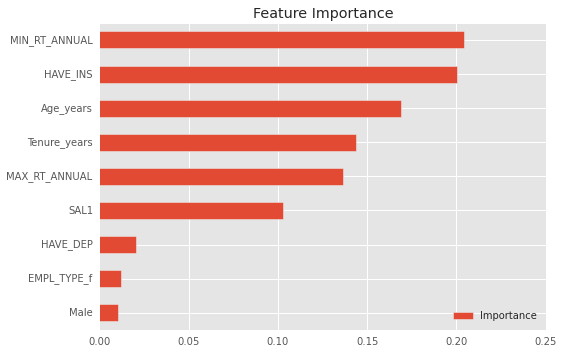

,Percentage


[]


[]


[]


[]


[]


[]


[]


,Importance
MIN_RT_ANNUAL,0.204032
HAVE_INS,0.200475
Age_years,0.169064
Tenure_years,0.143877
MAX_RT_ANNUAL,0.136459
SAL1,0.102616
HAVE_DEP,0.020788
EMPL_TYPE_f,0.012251
Male,0.010438


In [451]:
br.get_initial_analysis(X[minimum_cols],y,Xeval[minimum_cols])

In [456]:
minimal_input_col_list = ['KEY','HIRE_DT','BIRTHDATE','SAL1','HAVE_INS','HAVE_DEP','EMPL_TYPE','Male',
                          'MAX_RT_ANNUAL','MIN_RT_ANNUAL','PERF1','MERIT1','BOX1','INTERN','HUBIND']
empl[minimal_input_col_list].head()

,KEY,HIRE_DT,BIRTHDATE,SAL1,HAVE_INS,HAVE_DEP,EMPL_TYPE,Male,MAX_RT_ANNUAL,MIN_RT_ANNUAL,PERF1,MERIT1,BOX1,INTERN,HUBIND
0,490903510940682,2014-06-09 00:00:00,1993-09-05 00:00:00,16099.20,0,0,H,0,38026.9,22400.90,NaN,NaN,NaN,0,1
1,867989974034945,2002-08-05 00:00:00,1976-03-08 00:00:00,58551.95,0,0,E,0,84150.0,46096.11,1999.88,2999.82,2,0,0
2,704793881953132,2002-03-04 00:00:00,1976-01-20 00:00:00,31107.54,0,0,E,1,59760.0,32280.00,NaN,NaN,NaN,0,0
3,850716555421574,2012-12-10 00:00:00,1988-02-24 00:00:00,31045.35,1,0,E,1,51294.0,31045.35,1012.50,4208.72,2,0,1
4,868936932119046,1988-02-08 00:00:00,1939-03-26 00:00:00,36709.53,0,0,E,1,999999.0,0.00,0.00,0.00,NaN,0,0


## ASIDE
* looking at info for testdata

In [465]:
keys_to_get = ['"929965184037557"',
 '"872454415016088"',
 '"247046588569436"',
 '"980835578861104"',
 '"831802700567899"',
 '"612245620047788"',
 '"673774298594228"',
 '"53680010164939"',
 '"361010560468310"',
 '"688423451822448"']

In [467]:
for a in keys_to_get:
    print a,em2002[em2002.KEY == a.strip('"')][['HAVE_INS','HAVE_DEP']].values

"929965184037557" [[ 1.  0.]]
"872454415016088" [[ 1.  1.]]
"247046588569436" [[ 1.  1.]]
"980835578861104" [[ 1.  1.]]
"831802700567899" [[ 1.  0.]]
"612245620047788" [[ 1.  1.]]
"673774298594228" [[ 1.  0.]]
"53680010164939" [[ 1.  1.]]
"361010560468310" [[ 1.  1.]]
"688423451822448" [[ 1.  0.]]


In [469]:
for a in keys_to_get:
    print a,em2002[em2002.KEY == a.strip('"')][['Male']].values

"929965184037557" [[1]]
"872454415016088" [[0]]
"247046588569436" [[0]]
"980835578861104" [[0]]
"831802700567899" [[1]]
"612245620047788" [[0]]
"673774298594228" [[0]]
"53680010164939" [[0]]
"361010560468310" [[1]]
"688423451822448" [[0]]


In [475]:
for c in em2002[minimal_input_col_list]:
    print c, em2002[c].dtype

 KEY object
HIRE_DT object
BIRTHDATE object
SAL1 float64
HAVE_INS float64
HAVE_DEP float64
EMPL_TYPE object
Male int64
MAX_RT_ANNUAL float64
MIN_RT_ANNUAL float64
PERF1 float64
MERIT1 float64
BOX1 float64
INTERN int64
HUBIND int64


In [476]:
min_col_list = ['KEY','HIRE_DT','BIRTHDATE',
                'SAL1','PERF1','MERIT1','BOX1','MAX_RT_ANNUAL','MIN_RT_ANNUAL',
            'HAVE_INS','HAVE_DEP','EMPL_TYPE','Male',
                          'INTERN','HUBIND']

In [479]:
em2[min_col_list]

,KEY,HIRE_DT,BIRTHDATE,SAL1,PERF1,MERIT1,BOX1,MAX_RT_ANNUAL,MIN_RT_ANNUAL,HAVE_INS,HAVE_DEP,EMPL_TYPE,Male,INTERN,HUBIND
49367,35025035978772,1974-02-20 00:00:00,1946-10-10 00:00:00,59169.600,2416.09,0.00,2,67900.000,35800.000,1,0,E,0,0,0
86464,685743467735938,1995-11-06 00:00:00,1970-05-11 00:00:00,48819.900,0.00,0.00,NaN,0.000,0.000,0,0,N,1,1,0
40829,76975957526349,1988-08-08 00:00:00,1963-04-14 00:00:00,77188.500,1606.50,688.50,2,78795.000,45791.330,0,0,E,1,0,1
85328,290385969118395,1980-01-28 00:00:00,1946-10-15 00:00:00,49328.260,1884.71,1828.73,2,62775.000,36900.000,0,0,E,0,0,0
36315,358754032924191,1997-12-01 00:00:00,1973-07-19 00:00:00,64756.770,2554.04,1849.47,2,78795.000,45791.330,0,0,E,0,0,0
118281,542343335944388,1985-01-28 00:00:00,1961-05-25 00:00:00,98516.200,2798.21,2026.29,2,111832.430,67796.800,1,1,S,1,0,1
45455,393496309124630,2014-06-23 00:00:00,1974-12-29 00:00:00,24000.000,NaN,NaN,NaN,38026.900,22400.900,1,0,E,0,0,1
50901,996175121048547,2012-01-16 00:00:00,1987-09-13 00:00:00,30000.000,NaN,NaN,NaN,42775.490,25175.160,1,0,E,1,0,0
65887,103189568549017,1988-01-04 00:00:00,1952-10-22 00:00:00,89616.550,3042.00,2202.83,2,105259.110,62360.140,1,0,S,0,0,0
15894,540804458568247,1975-12-15 00:00:00,1946-10-29 00:00:00,62710.930,1481.36,987.57,2,84150.000,44753.500,1,0,E,0,0,0


In [472]:
pipe_small_0 = pipe()

0         0
1         0
2         0
3         0
4         1
5         1
6         0
7         0
8         0
9         0
10        0
11        1
12        1
13        0
14        1
15        0
16        0
17        1
18        0
19        0
20        1
21        1
22        1
23        0
24        0
25        1
26        0
27        1
28        1
29        0
         ..
134206    1
134207    1
134208    1
134209    0
134210    0
134211    0
134212    0
134213    0
134214    1
134215    1
134216    1
134217    0
134218    1
134219    0
134220    0
134221    1
134222    0
134223    0
134224    0
134225    1
134226    0
134227    1
134228    0
134229    1
134230    0
134231    0
134232    0
134233    0
134234    1
134235    0
Name: HUBIND, dtype: int64

In [ ]:
pipe_categorical_features = Pipeline([ ('factor_encode', br.ConvertCategorical(cat_cols_to_label_encode))])

In [144]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('factorize', Pipeline([
            ('extract', ColumnExtractor(cat_cols_to_label_encode)),
            ('factor_encode',br.ConvertCategorical(cat_cols_to_label_encode))                                
            #('scale', Normalizer())
        ])),
        ('dummy', Pipeline([
            ('extract', ColumnExtractor(cat_cols_to_dummy_encode)),
            ('dummy_encode',br.ConvertCategorical(cat_cols_to_dummy_encode,method='dummy'))
            #('one_hot', OneHotEncoder(n_values=5)),
            #('to_dense', DenseTransformer())
        ]))
                    ]))])

In [132]:
tmp_cols = []
tmp_cols += cat_cols_to_label_encode
tmp_cols += cat_cols_to_dummy_encode
len(tmp_cols), len(cat_cols_to_label_encode)

(10, 3)

In [137]:
pipe_categorical_features = Pipeline(steps=[('tmp_cat_feat', FeatureUnion(transformer_list=[
        ('factor_encode',br.ConvertCategorical(cat_cols_to_label_encode)),
        ('dummy_encode', br.ConvertCategorical(cat_cols_to_dummy_encode,method='dummy'))
        
    ]))])
#ft = categorical_features.fit_transform(em2[tmp_cols])

In [148]:
#ft = pipeline.fit_transform(em2[tmp_cols])
ft = pipe_categorical_features.fit(em2[tmp_cols],em2['retired']).transform(em2[tmp_cols])

In [149]:
np.shape(ft), np.shape(em2[tmp_cols])

((107388, 59), (107388, 10))

In [ ]:
pipeline = Pipeline([
    # preprocess the categorical data
    ('subjectbody', SubjectBodyExtractor()),

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('subject', Pipeline([
                ('selector', ItemSelector(key='subject')),
                ('tfidf', TfidfVectorizer(min_df=50)),
            ])),

            # Pipeline for standard bag-of-words model for body
            ('body_bow', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=50)),
            ])),

            # Pipeline for pulling ad hoc features from post's body
            ('body_stats', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'subject': 0.8,
            'body_bow': 0.5,
            'body_stats': 1.0,
        },
    )),

    # Use a SVC classifier on the combined features
    #('svc', SVC(kernel='linear')),
])

## Utilize pipeline to preprocess the categorical data

In [105]:
pp_category_pipe = Pipeline([("cat_le",br.ConvertCategorical(cat_cols_to_label_encode)),
                            ("cat_dummy",br.ConvertCategorical(['FULL_PART_TIME','COMPANY'],method='value_counts'))])
#("cat_survmed",br.Convert)]
# this is the same as factorize ( I think)


In [ ]:
pipe = Pipeline([("catd", br.ConvertCategorical(cat_cols_to_dummy_encode, method='dummy')),
                 ("catf", br.ConvertCategorical(cat_cols_to_label_encode))])
ft= pipe.fit_transform(em2)
                 #("imp", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.3)),
                 #("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])

In [ ]:
ft = pp_category_pipe.fit_transform(em2)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8*1-.8))
sel.fit_transform(em2[cols_categorical])

In [ ]:
br.get_columns_with_nulls(em2[cols_categorical])

In [ ]:
## create a class for this


In [ ]:
pipe = Pipeline(['impute',])

In [ ]:
# break into X and Xeval groups


In [ ]:
from sklearn.pipeline import Pipeline
cate_list = br.get_categorical_list(X)
pipe = Pipeline([("null", br.RemoveAllNull()),                   
                 ("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("imp", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.3)),
                 ("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])
pipe.fit(X, y).transform(testX)[0:10]

In [ ]:
#### create a new list of cols_to_keep


In [ ]:
#catdummy = br.ConvertCategorical(categorical_columns=[['LOC_STATE','LOC_TYPE_DESCR_SFI']],rows_to_scan='all')
#catdummy.fit(em2, em2['terminated']).transform(em2eval)[0:10]

In [ ]:
for c in em2002[['LOC_STATE','LOC_TYPE_DESCR_SFI']].columns:
    print c
    print len(em2002[c].unique())

In [ ]:

cols_to_survival = ['GRADE','JOB_FAMILY','JOB_FUNCTION','LOCATION']
cols_to_cat_encode = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME']
cols_to_label_encode = ['LOC_TYPE_DESCR_SFI','LOC_STATE']

In [ ]:
#br.get_percentage_of_nulls_pd(em2002)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
my_prob_thresh = .8
sel = VarianceThreshold(threshold=(my_prob_thresh*(1 - my_prob_thresh)))
sel.fit_transform(em2002[['FLSA_STATUS','FLOR_SFI','Male','INTERN']])

## helper functions follow

In [ ]:
def assign_unempl_rate(my_date,unempl):
    try :
        un_rate = unempl[unempl.index <= my_date]['value'].values[-1]
    except IndexError:
        un_rate = unempl['value'].ix[0]
        
    return un_rate

In [ ]:
# function to truncate POSTAL_ZIP to zip5
def truncate_postal_zip(in_zip):
    try:
        out_zip = in_zip[:5]
        #print out_zip
    except:
        #out_zip = str(in_zip)[:5]
        out_zip = np.nan
    return out_zip

In [ ]:
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,sep = ';',dtype_dict = None):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    if dtype_dict != None:
        df = pd.read_csv(inname,sep=sep,dtype =dtype_dict)
    else:
        df = pd.read_csv(inname,sep=sep)
    # clean up local filespace
    !rm {inname}
    return df

In [ ]:
def summarize_dataframe2(df,show_example=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    # assing fraction of missing
    summary_df['x_missing'] = summary_df['nmissing']/float(nrow)
    
    return summary_df

###check on various  encoded variables

* arity = 4, for 'SHIFT' map 'N' --> 0 and make FULL_PART_TIME categorical
* arity = 5 -- make EMPL_TYPE to categorical
* arity = 6, fine
* arity = 7, make COMPANY categorical
* arity = 8,9,10, fine
* arity = 11: EEO1CODE to categorical
* arity = 12: EMPL_CLASS to categorical
* arity = 19: JOB_FUNCTION to categorical

In [ ]:
#sdf[sdf.arity==4]
# dictonary of ratings
ratings_dict = {}
high_ratings = ['R3C3','R3C2','L3EXC','L3-EXC','OTSD','L3PRO','L3-PRO',
                'EXCELS','SUPR','EXC/SUS','EXC/IMP','PEXE','ME - MEETS']
low_ratings = ['IMPR','L1INC','L1DEV','L1PRO','NTAC','R1C2','R1C3','INC/DEC',
               'INC/SUS','INC/IMP','INCNSSTE','L1EXC','UNAC','R1C1','L2-INC','L2INC',
               'L1-EXC','L1-PRO','BEXP','L1-DEV','L1-INC','DNM - DOES','R3C1','R2C1']
solid_ratings = ['R2C3','R2C2','L2EXC','L2PRO','EXPE','/EX/','COMM','AOBJ','EXC/DEC',
                 'PRO/IMP','PRO/SUS','PRO/DEC','SM - SUCCE','MS - MEETS','L2DEV','L3INC',
                 'L3DEV','L2-DEV','L3-INC','ACPT','L3-DEV','L2-EXC','L2-PRO']

# initialize
for rating in high_ratings:
    ratings_dict[rating] = 3
for rating in low_ratings:
    ratings_dict[rating]=1
for rating in solid_ratings:
    ratings_dict[rating]=2


# function for assigning
def assign_simple_rating(x,my_dict = ratings_dict):
    try:
        rval = my_dict[x.strip()]
    except KeyError:
        rval = 0
    except AttributeError:
        rval = 0
    return rval

In [ ]:
### For Rate replace solid with 2, High with 3, Low with 1
#rate_col_list = [x for x in empl_bene.columns if x.startswith('RATE')]
#print len(rate_col_list)
#empl_bene[rate_col_list] = empl_bene[rate_col_list].applymap(lambda x: assign_simple_rating(x))
##empl[rate_col_list] = empl[rate_col_list].map(lambda(x): assign_simple_rating(x)).copy()
#empl_bene[rate_col_list].head()

In [ ]:
cat_description = br.describe_categorical(em2002[cols_categorical])
cat_description

In [ ]:
em2002[['SAL1','SAL2']].corr()

In [ ]:
em2002['SAL2'].describe()

In [ ]:
len(numeric_to_impute)

In [ ]:
numeric_to_impute

In [ ]:
len(list(set(cols_numeric) - set(mos_cols) - set(useful_time_cols) - set(potential_target_cols)-set(numeric_to_impute)))

In [ ]:
[c for c in list(set(cols_numeric) - set(mos_cols) - set(useful_time_cols) - set(potential_target_cols)-set(numeric_to_impute))]

In [ ]:
em2002[['TOT_MO_SERVICE_SFI','Tenure_years']].corr()

In [ ]:
em2002['FLOR_SFI'].value_counts()

In [ ]:
em2002['INTERN'].value_counts()

In [ ]:
em2[recentcols].describe()

In [ ]:
br.get_percentage_of_nulls_pd(em2,recentcols)

## Attempt to apply pipeline logic

In [ ]:
len(em2build.columns)

In [ ]:
fixzero=br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL'], criteria_coef=('percentile', 10), 
                            method = 'lower', fill_with='nearest_value')#,   
fixboth = br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef =('percentale',10),
                              method='both',fill_with='nearest_value')

In [ ]:
pipe0 = Pipeline('extract_cols', selectColumns(),
                'fixzero', fixzero(),
                'fixboth',fixboth(),
                'impute_numeric',br.ImputeData(columns_to_impute=['MERIT1','PERF1','ADDRCNT'])

In [ ]:
class selectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, )

In [ ]:
class RemoveAllNull(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_check='all'):
        """
        A class that can be inserted into pipeline.
        This will remove the columns with all missing values in the columns_to_check
        
        Parameter:
        ----------
        columns_to_check: string or list, optional (default="all")
            If "all", check all columns. Other 
            strings are interpreted to represent column names and you can 
            pass a list of column names to check.
        -----------
        
        returns a pandas dataframe
        """
        self.columns_to_check = columns_to_check
    
    def fit(self, X, y=None):
        self.columns_to_remove = get_columns_with_all_nulls(X, self.columns_to_check)
        return self
    def transform(self, X, y=None):
        X_temp = X.copy()
        for col in X_temp.columns:
            if col in self.columns_to_remove:
                X_temp.pop(col)
        return X_temp

In [ ]:
from sklearn.pipeline import Pipeline,FeatureUnion

In [ ]:
pipe0 = Pipeline(['col_drop', ])

In [ ]:
feature_extraction0 = FeatureUnion(['med_surv',medianSurvival(),
                                   'continuous',])
pipeline0 = Pipeline([
  ('extract_essays', EssayExractor()),
  ('features', FeatureUnion([
    ('ngram_tf_idf', Pipeline([
      ('counts', CountVectorizer()),
      ('tf_idf', TfidfTransformer())
    ])),
    ('essay_length', LengthTransformer()),
    ('misspellings', MispellingCountTransformer())
  ])),
  ('classifier', MultinomialNB())
])

In [ ]:
fixrate1 = br.FixNumericOutlier(columns_to_fix = ['MIN_RT_ANNUAL','']

In [ ]:
from sklearn.pipeline import Pipeline
cate_list = br.get_categorical_list(X)
pipe = Pipeline([("null", br.RemoveAllNull()),                   
                 ("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("imp", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.3)),
                 ("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])
pipe.fit(X, y).transform(testX)[0:10]

## Step through the DF with bear
1. list all columns
2. find those that have all nulls
3. find those that have any missing

In [ ]:
# check if any column has all missing
chk_for_null_columns = br.get_columns_with_all_nulls(empl_bene)
if len(chk_for_null_columns) > 0:
    print "WARNING there are {0} columns that are completely null.".format(chk_for_null_columns)
    print chk_for_null_columns
    empl_bene.drop(chk_for_null_columns,axis=1,inplace=True)
else:
    print "there were no columns that were universally null."
    


# encode some categorical

In [ ]:
# identify the columns with missing data
cols_with_missing_data = br.get_columns_with_nulls(empl_bene)
if len(cols_with_missing_data)==0:
    print "there were no columns with missing data."
else:
    print "WARNING there are {0} columns that have missing data.".format(len(cols_with_missing_data))
    print "These columns are:\t",cols_with_missing_data

In [ ]:
# Partition these with missing values into categorical/boolean/numeric
all_numeric_cols = br.get_numeric(empl_bene)
all_cat_cols = br.get_categorical(empl_bene)
print len(all_numeric_cols),len(all_cat_cols)

In [ ]:
## which columns are numeric and have missing?
print len(list(set(all_numeric_cols).intersection(set(cols_with_missing_data))))
print len(list(set(all_cat_cols).intersection(set(cols_with_missing_data))))

In [ ]:
sdf.sort('nmissing',ascending=False)

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder() #assigns unique integers to values base upon alphabetical order.

In [ ]:
boolean_cols = sdf[(sdf.arity==2) & (sdf.datatype=='object')].Column.values
print boolean_cols
for c in boolean_cols:
    print c, sdf[sdf.Column==c]['accepted values']

In [ ]:
for col in boolean_cols:
    empl_bene[col] = label_encoder.fit_transform(empl_bene[col]) # use sklearn.preprocesing.LabelEncoder()



In [ ]:
[a for a in em2002[em2002.FULL_PART_TIME_X==1].columns if a.endswith('months')]
em2002[em2002.FULL_PART_TIME_X==1].Tenure_months.describe()#hist(normed=True)
#em2002[em2002.FULL_PART_TIME_X!=1].Tenure_months.hist(normed=True)

In [ ]:
em2002[em2002.FULL_PART_TIME_X==0].Tenure_months.describe()

In [ ]:
empl_bene.FULL_PART_TIME.value_counts(), empl_bene.EMPL_TYPE.value_counts()

In [ ]:
cols_to_categorical_1 = br.get_categorical(em2002[cols_to_consider1])
for c in cols_to_categorical_1:
    print c, len(em2002[c].unique()), sum(em2002[c].isnull())

In [ ]:
def create_factorized_df(input_df,column_name):
    tmp_df = pd.get_dummies(input_df[column_name],prefix=column_name)
    # now drop the largest category
    lgst_category = input_df[column_name].value_counts().index[0]
    #print tmp_df.shape, tmp_df.columns
    #print lgst_category
    base_category = column_name+'_'+str(lgst_category)
    tmp_df.drop(base_category,axis=1,inplace=True)
    print tmp_df.shape, base_category
    return tmp_df,base_category

In [ ]:
missing_cols2_as_floats =[]
missing_cols2_as_cats = []
for c in list_with_missing2:
    my_dtype = em2002[c].dtype
    
    if my_dtype == np.float64:
        
        missing_cols2_as_floats.append(c)
    else:
        print c, sum(em2002[c].isnull()), em2002[c].dtype
        missing_cols2_as_cats.append(c)
        
print len(missing_cols2_as_floats)

In [ ]:
em2002['LOC_STATE'].fillna('XX',inplace=True)
em2002['GRADE'].fillna('XXX',inplace=True)
em2002['JOB_FAMILY'].fillna('XXXXX',inplace=True)
em2002['LOC_TYPE_DESCR_SFI'].fillna('UNKNOWN LOCATION TYPE',inplace=True)
em2002['JOB_FUNCTION'].fillna('XXX',inplace=True)
cols_to_survival = ['GRADE','JOB_FAMILY','JOB_FUNCTION','LOCATION']
cols_to_cat3 = ['EMPL_CLASS','EEO1CODE','EMPL_TYPE','FULL_PART_TIME']
cols_to_label_encode = ['LOC_TYPE_DESCR_SFI','LOC_STATE']

em2002.drop('LEGACY_DEPT_SFI',axis=1,inplace=True)



In [ ]:
em2002.COMPANY.value_counts()

In [ ]:
# create a dummified dataframe.
base_category_list =[]
dummy_categories_list = []
print em2002.shape
for acol in cols_to_cat3:
    print acol
    t_df,bc1 = create_factorized_df(em2002,acol)
    # drop the original column
    #new_col_names = t_df.columns.tolist()
    #dummy_categories_list+=new_col_names
    em2002.drop(acol,inplace=True,axis=1)
    # append the factorized categories
    em2002 = pd.concat([em2002,t_df],axis=1)
    base_category_list.append(bc1)

print em2002.shape,len(base_category_list)

In [ ]:
base_category_list

In [ ]:
for acol in cols_to_cat3:
    #if acol != 'EMPL_CLASS':
    cols_to_consider1.remove(acol)
    added_cols = [x for x in em2002.columns if x.startswith(acol)]
    cols_to_consider1+=added_cols
cols_to_consider1.remove('LEGACY_DEPT_SFI')
len(cols_to_consider1)

In [ ]:
## Label Encode those 2 columns: LOC_STATE and LOC_TYPE_DESCR_SFI
for acol in cols_to_label_encode:
    label_encoder.fit_transform(em2002[acol])

In [ ]:
[x for x in cols_to_consider1 if 'FUNC_ID' in x]
# add these to the cols_to_survival

In [ ]:
em2002.EXT_FUNC_ID_SFI.isnull().sum()

In [ ]:
print len(em2002.FUNC_ID_SFI.unique()), len(em2002.EXT_FUNC_ID_SFI.unique())
cols_to_survival.append('FUNC_ID_SFI')
cols_to_survival.append('EXT_FUNC_ID_SFI')
cols_to_survival


In [ ]:
my_list_of_missing_cols = br.get_columns_with_nulls(em2002[cols_to_consider1])
missing_counts_cols = [x for x  in my_list_of_missing_cols if 'CNT' in x]
print missing_counts_cols


In [ ]:
# make these 'counts' go to -1 for missing
for acolumn in missing_counts_cols:
    em2002.fillna({acolumn: -1},inplace=True)


In [ ]:
my_list_missing_2 = br.get_columns_with_nulls(em2002[cols_to_consider1])
print len(my_list_missing_2)

In [ ]:
[x for x in em2002.columns if x.startswith('EMPL_CLASS')]

In [ ]:
class ColumnExtractor(TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def transform(self, X, **transform_params):
        return X[self.columns]

    def fit(self, X, y=None, **fit_params):
        return self

## Correct values for the floats:
* if min value (MIN_RT_ANNUAL)
    * is zero reset to min value
    * is nan reset to median?
* if max value  (MAX_RT_ANNUAL) is 
    * zero reset to min value
    * nan reset to median?
    
#### examine how many of these are the cases

In [ ]:
print sum(em2002.MAX_RT_ANNUAL <= 1), sum(em2002.ANNUAL_RT <= 1), sum(em2002.MIN_RT_ANNUAL<=1)

In [ ]:
my_value = 0
salary_cols = ['MIN_RT_ANNUAL','MAX_RT_ANNUAL','ANNUAL_RT']
for col in salary_cols:
    #my_mtd = 'max'
    my_data = em2002[em2002[col]!=my_value][col]
    print col, my_data.min(), my_data.max(), my_data.mean(), my_data.median()
#em2002[em2002['MAX_RT_ANNUAL']!=my_value]['MAX_RT_ANNUAL'].median()

In [ ]:
print len(em2002[em2002['ANNUAL_RT']==0])#['ANNUAL_RT'].value_counts()

In [ ]:
em2002[em2002['MAX_RT_ANNUAL']<999999]['MAX_RT_ANNUAL'].max()

In [ ]:
em2002[em2002['ANNUAL_RT']==0][['BIRTHDATE','TERMINATION_DT','HIRE_DT','GRADE','MAX_RT_ANNUAL']]#[cols_to_consider1]

In [ ]:
[a for a in em2002.GRADE.unique() if a.startswith('C')]

In [ ]:
len(em2002[em2002.GRADE == 'C23'][['TERMINATION_DT','ANNUAL_RT']])

In [ ]:
class FixZeroValues(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_fix, value_to_replace=0, method='median'):
        #criteria_coef=('percentile', 5), fill_with='nearest_value', 
        #         method='both', columns_to_fix='all', rows_to_scan='all'):
        #def __init__(self, categorical_columns, method='factorize', rows_to_scan='all'):
        """
        A class that can be inserted into a pipeline.
        
        This will fix the values in numeric columns of the dataframe that are artificially assigned 
        as zeros. Columns with all nulls or categorical values will not be changed.
        Missing values will remain missing. Inf values will be fixed.
        
        Parameters
        ---------
        X: Pandas dataframe
        
        columns_to_fix: a list of column names, the columns should be numerical.
        
        value_to_replace: int or float. This is the 'zero' that is being replaced
            TODO make this able to accept a dictionary?
        
        method: str, default='median'. How the zero values will be replaced.
            Others can be 'mean', 'min', 'max', or a specific value (entered as a string).
        
        
        returns a pandas dataframe
        """
        self.method = method
        self.columns_to_fix = columns_to_fix
        self.value_to_replace = value_to_replace
        
    def fit(self, X, y=None):
        self.map_values = {}
        self.new_values = {}
        
        for col in self.columns_to_fix:
            my_values = X[col]!=value_to_
            if self.method == 'median':
                map_values = X[col].
                 yy = y[:rows_to_scan_in].copy()
                self.map_values[col] = dict(pd.crosstab(XX[col], y).apply(lambda x: x[1]/float(x.sum()), axis=1))
        if self.criteria_coef != 'all':
            
            self.max_val = {}
            self.min_val = {}
            self.coef = self.criteria_coef[1]
            self.criteria = self.criteria_coef[0]
            rows_to_scan_in = get_rows_to_scan(self.rows_to_scan, X.shape[0])
                      
            if self.columns_to_fix == 'auto':
                self.columns_to_fix_in = get_numeric(X)
            else:
                self.columns_to_fix_in = get_list_of_columns_to_check(self.columns_to_fix, X.columns)

            temp_numeric = get_numeric(X[self.columns_to_fix_in])
            temp_not_numeric = set(self.columns_to_fix_in)-set(temp_numeric)
            if len(temp_not_numeric) > 0:
                raise Exception('Columns '+str(list(temp_not_numeric))+' are not numeric!')
            XX = X[:rows_to_scan_in].copy()
            for col in self.columns_to_fix_in:
                temp = XX[col][np.isfinite(XX[col])]
                if self.criteria == 'percentile':
                    self.max_val[col] = np.percentile(temp, 100-self.coef)
                    self.min_val[col] = np.percentile(temp, self.coef)
                elif self.criteria == 'sd':
                    self.max_val[col] = np.mean(temp)+self.coef*np.std(temp)
                    self.min_val[col] = np.mean(temp)-self.coef*np.std(temp)
        return self
    
    def transform(self, X, y=None):
        if self.criteria_coef != 'all':
            XX = X.copy()
            if self.fill_with == 'nearest_value':
                if self.method == 'upper':
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] > self.max_val[col], col] = self.max_val[col]
                elif self.method == 'lower':
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] < self.min_val[col], col] = self.min_val[col]
                else:
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] > self.max_val[col], col] = self.max_val[col]
                        XX.loc[XX[col] < self.min_val[col], col] = self.min_val[col]
            elif self.fill_with == 'missing':
                if self.method == 'upper':
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] > self.max_val[col], col] = np.nan
                elif self.method == 'lower':
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] < self.min_val[col], col] = np.nan
                else:
                    for col in self.columns_to_fix_in:
                        XX.loc[XX[col] > self.max_val[col], col] = np.nan
                        XX.loc[XX[col] < self.min_val[col], col] = np.nan
            return XX
        else:
            return X

In [ ]:
print em2002.MIN_RT_ANNUAL.describe()
print sum(em2002.MIN_RT_ANNUAL <=1)
em2002[em2002.MIN_RT_ANNUAL>1].MIN_RT_ANNUAL.min()

## NOW to define the imputation approaches
* by Mean/median/min?
* by Survival function
* by counts

In [ ]:
most_recent_missing_col = [ c for c in my_list_missing_2 if c.endswith('1')]
most_recent_missing_col

In [ ]:
## Now I need to split into build-eval set

In [ ]:
em2002.terminated.value_counts()

In [ ]:
print len(em2002.columns)
cols_to_survival

In [ ]:
print len(columns_to_omit), len(columns_to_omit_2)
columns_to_omit_2

In [ ]:
cols_to_label_encode.append('COMPANY')

In [ ]:
set(em2002.columns.tolist()) - set(columns_to_omit_2)

In [ ]:
len(cols_to_consider1), len(my_list_missing_2)

In [ ]:
[(a,em2002[a].isnull().sum(), em2002[a].median(), em2002[a].mean()) for a in my_list_missing_2]

## Use cols_to_consider1
* Create a test train split
* then use pipelines for the following
* try to apply class that adjusts the missing values in my_list_missing_2 to median?
* try to apply class that adjusts the zero values of 

In [ ]:
columns_to_omit_2

In [ ]:
#replace in the cols_to_consider list
cols_to_consider = [a for a in cols_to_consider1 if not a.startswith('Tenure')]
print len(cols_to_consider),len(cols_to_consider1)
cols_to_consider.append('Tenure_years')

## Label encode the 3 like that
* and alter the cols_to_consider listing

In [ ]:
for col in cols_to_label_encode:
    newcol = 'le_'+col.lower()
    cols_to_consider.remove(col)
    cols_to_consider.append(newcol)
    print col,newcol
    em2002[newcol] = label_encoder.fit_transform(em2002[col]) # use sklearn.preprocesing.LabelEncoder()

print len(cols_to_consider)
cols_to_consider[-8:]

In [ ]:
# split the training data into two parts
from sklearn.cross_validation import train_test_split
emBuild, emEval = train_test_split(em2002, test_size=0.25, random_state=92)

In [ ]:
print np.shape(emBuild), np.shape(emEval)

In [ ]:
# reset the indices of these two sets and the dates
emBuild_dates = empl_dates.ix[emBuild.index].copy()
emEval_dates = empl_dates.ix[emEval.index].copy()
#build_indices = emBuild.index
#eval_indices = emEval.index
emBuild.index = np.arange(0,len(emBuild))
emBuild_dates.index = np.arange(0,len(emBuild))
emEval.index = np.arange(0,len(emEval))
emEval_dates.index= np.arange(0,len(emEval))

In [ ]:
numeric_consider_A = br.get_numeric(emBuild[cols_to_consider])
print len(numeric_consider_A)

## apply the survival function to the remaining 6
* first calculate the tenure in years (done above)
* create dictionary based upon the build set


In [ ]:
for i,col in enumerate(cols_to_survival):
    print col, emBuild[col].unique().dtype

In [ ]:
#job_related_cols = ['JOBCODE','grade_code','job_fcode']
#new_job_sf_cols = ['surv_med_jobcode','surv_med_grade','surv_med_jobfamily']
list_sf_dict = []
new_surv_med_cols =[]
for i, col in enumerate(cols_to_survival):
    # check type of column and cast as str
    my_dtype = emBuild[col].unique().dtype
    if my_dtype == 'float64':
        #print col
        emBuild[col].apply(lambda x: np.str(x))    
        emEval[col].apply(lambda x: np.str(x))    

    num_cutoff=40
    newcol = 'survmed_'+col.lower()
    nuniq = len(emBuild[col].unique())
    if nuniq < num_cutoff:
        num_cutoff = nuniq
    else:
        num_cutoff = int(nuniq/4.)

    frac_accounted_for = emBuild[col].value_counts().iloc[:num_cutoff].sum()/float(len(emBuild))
    print i,col,newcol, nuniq, num_cutoff,num_cutoff/float(nuniq),frac_accounted_for
    # I want to make this fraction close to 80%?
    
    #len(emBuild[col].value_counts())
    #if nuniq < num_cutoff:
    #    num_cutoff = nuniq
    # calc survival functions
    sf_df = calculate_survival_functions(emBuild,'Tenure_years', 'terminated', col,num_cutoff)
    ## create the dictionary
    list_sf_dict.append(return_first_time_survival(sf_df,thresh=0.5))
    # apply the dictionary and create a new column
    new_surv_med_cols.append(newcol)
    emBuild[newcol]= emBuild[col].apply(lambda x: list_sf_dict[i][x])
    emEval[newcol] = emEval[col].apply(lambda x: list_sf_dict[i][x])
    cols_to_consider.remove(col)
    cols_to_consider.append(newcol)

    

## July 9, 2015 made it here

In [ ]:
## examine the values of these new columns
emBuild.survmed_grade.hist(label='Grade',bins=30)
emBuild.survmed_job_family.hist(alpha=0.7,label='Jobfamily',bins=30)
emBuild.survmed_job_function.hist(alpha=0.4,label='jobfcn',bins=30)
emBuild.survmed_location.hist(alpha=0.4,bins=30,label='location')
plt.legend(loc=2)
plt.title('Histograms of Median Survival time (months) from EmBuild set')
#emBuild.plot(kind='scatter',x =)

## Begin by looking at collinearity of the data in emBuild

In [ ]:
cols_with_missing_numeric = br.get_columns_with_nulls(emBuild[cols_to_consider])

### okay because of these missing values I need to impute/fill in
* try using median value (based upon emBuild)
* also apply fix_outliers to ANNUAL_RT, ...

In [ ]:
X = emBuild.copy()


In [ ]:
X.ANNUAL_RT.describe()

In [ ]:
# if categorical columns are included, an error will be raised
# this class is usually inserted after ConvertCategorical in pipelines
fixout=br.FixNumericOutlier(columns_to_fix=['ANNUAL_RT','MIN_RT_ANNUAL'], criteria_coef=('percentile', 10), 
                            method = 'lower', fill_with='nearest_value')
                            
X1 = fixout.fit(X).transform(X)
print X1['ANNUAL_RT'].describe()
X[['mod_annual_rt','mod_min_rt_annual']]=X1[['ANNUAL_RT','MIN_RT_ANNUAL']]
fixout_max = br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'], criteria_coef=('percentile', 10), 
                            method = 'both', fill_with='nearest_value')
X1 = fixout_max.fit(X).transform(X)
X['mod_max_rt_annual']=X1['MAX_RT_ANNUAL']

In [ ]:
imp = br.ImputeData(method='median', columns_to_impute=cols_with_missing_numeric, impute_inf=False, keep_dummies=False)
X1 = imp.fit(X).transform(X)
X[cols_with_missing_numeric]=X1[cols_with_missing_numeric]

In [ ]:
for a in ['ANNUAL_RT','MIN_RT_ANNUAL','MAX_RT_ANNUAL']:
    new_a = 'mod_'+a.lower()
    cols_to_consider.remove(a)
    cols_to_consider.append(new_a)
    

In [ ]:
br.perfect_collinearity_test(X[cols_to_consider])

In [ ]:
cols_to_consider

In [ ]:
model_columns = cols_to_consider

#model_columns.remove('retired')
for c in model_columns:
    if c.startswith('RATE'):
        model_columns.remove(c)
        print c, len(model_columns)

        
print len(model_columns)

In [ ]:
[c for c in model_columns if c.startswith('RATE')]

In [ ]:
model_columns.remove('terminated')
model_columns.remove('status')
model_columns.remove('sep_status')
print len(model_columns)

In [ ]:
br.perfect_collinearity_test(X[model_columns])

In [ ]:
model_columns.remove('unempl_rate') # hard to predict this

## progress toward the Temporal Fold work

In [ ]:
def create_temporal_kfolds(dates_df,date_range,time_delta):
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs
    

In [ ]:
def reset_years(paired_times,indices,dates_df,df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    
    
    return reset_age,reset_tenure


In [ ]:
def define_target_within_x_years(dates_df,df,paired_dates,tfold,n_years,target_col):
    print len(tfold)#, paired_dates

    df_dict = {}
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
        # if in the fold reset the age to start of fold; define new window of termination
        in_fold_idx = tfold[i][0]
        # note that "sex" is just used to create a value that then gets dummied out
        cols_to_copy = ['Male','Age_years','Tenure_years']
        cols_to_copy.append(target_col)
        #altered_fold_df= df[['SEX','Age_years','Tenure_years','terminated']].copy()
        altered_fold_df = df[cols_to_copy].copy()
        # adjust these
        altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_term']
        altered_fold_df.fold_mbr = 0

        ra,rt = reset_years(paired_dates,in_fold_idx,dates_df,df)
        altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        new_term = (dates_df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_term = (dates_df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_term']=new_term
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel

In [ ]:
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

In [ ]:
import itertools

In [ ]:
def setup_tfold_models(myX,dates,yr_val,cols_of_interest,tgt_value='terminated',date_range=full_date_range):
    # create the folds
    yr_tfolds,yr_times = create_temporal_kfolds(dates,date_range,yr_val)
    # create the panels (offset)
    myPanel = define_target_within_x_years(dates,myX,yr_times,yr_tfolds,yr_val,tgt_value)
    # create the tfold training sets
    #[(a,emBuild.ix[five_yr_tfolds[a][0]].terminated.sum()) for a in xrange(0,9)]
    Xfold = np.zeros((len(myX),len(cols_of_interest)+2,len(yr_tfolds)))
    ## So now
    yfold = []
    for i in xrange(0,len(yr_tfolds)):
        Xfold[:,:-2,i]=myX[cols_of_interest].as_matrix().astype(np.float)
        Xfold[:,-2:,i]=myPanel[i][['adj_age','adj_tenure']]
        my_y=myPanel[i][['adj_term']].as_matrix().astype(np.int)
        yfold.append(my_y)
    
    return yr_tfolds, yr_times, myPanel, Xfold, yfold
        

## build t_fold models

In [ ]:
tfold5,tfold5_times,panel5term,X5fold,y5fold = setup_tfold_models(X,emBuild_dates,5,model_columns)

In [ ]:
from sklearn import ensemble

In [ ]:

%%time
five_rf_mdl = []
for i in xrange(0,len(tfold5)):
    train_y = y5fold[i].flatten()[tfold5[i][0]]
    train_X = X5fold[tfold5[i][0],:,i]
    rfmdl = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
    rfmdl.fit(train_X,train_y)
#baseline_singleRFC = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
#baseline_singleRFC.fit(X,y_term)
#baseline_singleRFC_importances= baseline_singleRFC.feature_importances_
    five_rf_mdl.append(rfmdl)

In [ ]:
#
def adjust_eval_by_x_years(df,df_dates,year_val,modeling_columns,target_col='terminated'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (df.Tenure_years <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the termination to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    eval_adj_age.ix[eval_within_time_target_index] = df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns)+2)
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)+2))
    Xeval[:,:-2] = df.ix[eval_idx_to_use][modeling_columns].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    return Xeval, y_eval


## now apply each model to my eval set
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

In [ ]:
Xeval = emEval.copy()
#fixout=br.FixNumericOutlier(columns_to_fix=['ANNUAL_RT','MIN_RT_ANNUAL'], criteria_coef=('percentile', 10), 
#                            method = 'lower', fill_with='nearest_value')
                            
X1b = fixout.fit(X).transform(Xeval)
print X1b['ANNUAL_RT'].describe()
Xeval[['mod_annual_rt','mod_min_rt_annual']]=X1b[['ANNUAL_RT','MIN_RT_ANNUAL']]
#fixout_max = br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'], criteria_coef=('percentile', 10), 
#                            method = 'both', fill_with='nearest_value')
X1b = fixout_max.fit(X).transform(Xeval)
Xeval['mod_max_rt_annual']=X1b['MAX_RT_ANNUAL']

In [ ]:
#imp = br.ImputeData(method='median', columns_to_impute=cols_with_missing_numeric, impute_inf=False, keep_dummies=False)
X1b = imp.fit(X).transform(Xeval)
Xeval[cols_with_missing_numeric]=X1b[cols_with_missing_numeric]

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(Xeval,emEval_dates,5,model_columns,target_col='terminated')

In [ ]:
eval_pred_class5,eval_pred_proba5 = evaluate_models(five_rf_mdl,X5eval)

In [ ]:
from sklearn import metrics

In [ ]:
plot_conf_matrix(y5eval,map(np.int,eval_pred_class5.mean(axis=1)))

In [ ]:
plot_conf_matrix(y5eval,map(np.int,eval_pred_class5.mean(axis=1)),normed=False)

In [ ]:
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return roc_auc

In [ ]:
#plot_roc_curve(y3eval,eval_prediction_proba3[:,])
plot_roc_curve(y5eval,eval_pred_proba5[:,:,:].mean(axis=2))
plt.ylim([0,1.01])

## begin to explore the factors

In [ ]:
# function to push feature_importances for a set of RF models into a dataframe
def create_fi_df(mdl_list,feature_names):
    list_feature_importances = []
    col_list = []
    for i,mdl in enumerate(mdl_list):
        list_feature_importances.append(plotFI(mdl,feature_names,show_plot=False))
        col_list.append('fold'+str(i)+'_value')
        col_list.append('fold'+str(i)+'_std')

    fi_df = pd.concat(list_feature_importances,axis=1)
    # create column headings
    fi_df.columns = col_list
    # create the average of the values
    value_cols = [x for x in col_list if x.endswith('value')]
    
    fi_df['avg_val']=fi_df[value_cols].mean(axis=1)
    fi_df['avg_variance']=fi_df[value_cols].std(axis=1)
#t2_eval_fi_df[['avg_val','avg_std']].sort('avg_val',ascending=False)
    return fi_df

def plotFI(forest,featureNames=[],show_plot=True):#,autoscale=True,headroom=0.05):
    """
    forest is the model to be graphed.
    featureNames is the list of features to be displayed
    
    """
    #if autoscale:
    #    x_scale = forest.feature_importances_.max()+ headroom
    #else:
    #    x_scale = 1
    
    featureImportances=forest.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    estimators = forest.estimators_
    # calculate the variance over the forest 
    
    std = np.std([tree.feature_importances_ for tree in estimators],axis=0)
    # print summary statement
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    print("Number of Trees: %d" %(len(estimators)))
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    if show_plot:
        plt.title("Feature importances")
        plt.barh(range(len(kindices)), featureImportances[kindices],
           color="steelblue", xerr=std[kindices], align="center",ecolor='k')#,lw=2)
    
        plt.yticks(range(len(kindices)),fN2)
        #grid(True)
    
    c1 = 'value'
    c2 = 'std'
    tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = tdata.T,index=fN2,columns=[c1,c2])
    return df
    

In [ ]:
print len(five_rf_mdl[0].feature_importances_), len(model_columns)
feature_names1 = [a for a in model_columns]
feature_names1.append('adj_age')
feature_names1.append('adj_tenure')


In [ ]:
fiveRFmdl_fidf = create_fi_df(five_rf_mdl,feature_names1)

In [ ]:
from StringIO import StringIO
from sklearn import tree
out = StringIO()
out = tree.export_graphviz(five_rf_mdl[0].estimators_[0], out_file=out)


### so 52 of 164 columns have missing values still. Work on Correcting these.
#### some logic:
* if it is a count (like ADDRCNT*) set missing to -1

* if it is a performance assessment (like BOX*) set to 0; L will become 1, S will become 2, H will become 3.
* if it is a float (like MERIT*, PERF*, ...) try to reassign by imputation.
* assign a value:
    * if 'HAVE_INS' or 'HAVE_DEP' assign 0, 0 to values
    * if LOC_STATE or GRADE or JOB_FAMILY or JOB_FUNCTION or LOC_TYPE_DESCR_SFI assign to XX*

In [ ]:
chg_to_zero_cols = ['BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
#['HAVE_INS','HAVE_DEP','DEP_COUNT','BOX1','BOX2','BOX3','BOX4','BOX5','BOX6','BOX7','BOX8','BOX9','BOX10']
chg_to_neg_one_cols = ['ADDRCNT1','ADDRCNT3','ADDRCNT5','ADDRCNT10',
                           'DIRECT_RPT_CNT', 'DIVISION_CODE_SFI','EXTFUNC_CNT','FUNC_CNT','TOTAL_RPT_CNT']
                          
chg_to_MISSING_cols = ['ACTRES1','ACTRES2','ACTRES3','ACTRES4','ACTRES5','ACTRES6','ACTRES7','ACTRES8','ACTRES9','ACTRES10',
                      'ADDRESS1','JOB_FAMILY','LOC_CITY','LOC_TYPE_DESCR_SFI','SKEY',
                      'RATE1', 'RATE10', 'RATE2', 'RATE3', 'RATE4', 'RATE5', 'RATE6', 'RATE7', 'RATE8', 'RATE9',]
#chg_to_MISSING =['ACTRES1','ACTRES2','ADDRESS1','JOB_FAMILY', 'LOC_CITY','LOC_TYPE_DESCR_SFI']#'POSTAL_SFI',
chg_to_00000 = ['EXT_FUNC_ID_SFI','FUNC_ID_SFI']#,'zip5']
chg_to_XXX = ['GRADE','JOB_FUNCTION']
chg_to_XX = ['LOC_STATE']
col_to_drop = ['STATE','ADDRESS2','MAR_STATUS_DT'] # drop 'STATE'; some strange values; 'address2 x_missing too high'

In [ ]:
## map some categorical to their values

In [ ]:
empl

In [ ]:
## restrict 

## Remove extraneous columns
* historical ones
* PER_ORG (all the same)
* addresses
* SAL1 == ANNUAL_RT
## Actually the better option is to just extract the desired columns and do the modeling on these

In [ ]:
history_to_omit = ['ADDRCNT10','ADDRCNT3','ADDRCNT5','DEPTCNT10','DEPTCNT3','DEPTCNT5',
                   'EFUNCCNT10','EFUNCCNT3','EFUNCCNT5','FLOORCNT10','FLOORCNT3','FLOORCNT5',
                  'FTPTCNT10','FTPTCNT3','FTPTCNT5','FULLPART10','FULLPART3','FULLPART5',
                  'FUNCCNT10','FUNCCNT3','FUNCCNT5','GRADECNT10','GRADECNT3','GRADECNT5',
                  'JOBCNT10','JOBCNT3','JOBCNT5','LOCCNT10','LOCCNT3','LOCCNT5','LOCSTCNT10','LOCSTCNT3','LOCSTCNT5',
                  'PARTFULL10','PARTFULL3','PARTFULL5','PTFTCNT10','PTFTCNT3','PTFTCNT5',
                   'SUPVCNT10','SUPVCNT3','SUPVCNT5','SAL10','SAL9','SAL8','SAL7','SAL6','SAL5','SAL4','SAL3',
                   'SAL2','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                    'PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']

In [ ]:
# add the ACTRES2/3 and ADDRESS1/2 lines
# add *_tdelta, BIRTHDATE, PER_ORG
# add POSTAL_SFI, zip5, MAR_STA_SNAME_SFI, LOC_TYPE_DESC_SFI
others_to_omit = ['ADDRESS1','Age_tdelta','BIRTHDATE','LAST_HIRE_DT',
                  'LOC_CITY','LOC_TYPE_DESCR_SFI','MAR_STATUS_DT','MAR_STA_SNAME_SFI',
                  'PER_ORG','POSTAL_SFI','SKEY','SERVICE_DT','TERMINATION_DT',
                  'Tenure_tdelta','zip5']#'TOT_MO_SERVICE_SFI','Tenure_months']
                 #'MERIT1','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                 #'PERF1','PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
history_to_omit = ['ADDRCNT10','ADDRCNT3','ADDRCNT5','DEPTCNT10','DEPTCNT3','DEPTCNT5',
                   'EFUNCCNT10','EFUNCCNT3','EFUNCCNT5','FLOORCNT10','FLOORCNT3','FLOORCNT5',
                  'FTPTCNT10','FTPTCNT3','FTPTCNT5','FULLPART10','FULLPART3','FULLPART5',
                  'FUNCCNT10','FUNCCNT3','FUNCCNT5','GRADECNT10','GRADECNT3','GRADECNT5',
                  'JOBCNT10','JOBCNT3','JOBCNT5','LOCCNT10','LOCCNT3','LOCCNT5','LOCSTCNT10','LOCSTCNT3','LOCSTCNT5',
                  'PARTFULL10','PARTFULL3','PARTFULL5','PTFTCNT10','PTFTCNT3','PTFTCNT5',
                   'SUPVCNT10','SUPVCNT3','SUPVCNT5','ACTRES2','SAL10','SAL9','SAL8','SAL7','SAL6','SAL5','SAL4','SAL3',
                   'SAL2','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                    'PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
cols_to_categorical = ['COMPANY','COMP_FREQUENCY','DIVISION_CODE_SFI','EEO1CODE','EMPL_CLASS','EMPL_TYPE','ETHNIC_GROUP',
                       'FLSA_STATUS','FULLPART1','FULL_PART_TIME','GRADE','HUBIND','INTERN','JOB_FUNCTION','RELOCATE_ALL_SFI',
                       'REMOTE','REMOTE_SUPV','SEX','SHIFT','SUPV_DIFF_LOC','VOLINVOL','status']
for col in others_to_omit:
    columns_to_omit.append(col)

for col in history_to_omit:
    columns_to_omit.append(col)
    
print len(columns_to_omit),len(cols_to_categorical)

## READ the data June 10, 2015
* use employee_dataframe8.tsv --> contains text fields including dates for HIRE_DT..
* use employee_df_[1,2].csv --> contains just numeric data.
    - employee_df_1 has 180 columns:
        + Historical data there 
        + max value of EXT_FUNC_ID_SFI and FUNC_ID_SFI (represents missing ) changed to 2000.
        + median values used to fill missing values for float columns
        + COMPANY dropped
        + 'LOC_TYPE_DESCR_SFI','GRADE','LOC_STATE','JOB_FAMILY' label encoded
        + ANNUAL_RT droped in lieu of SAL1
        + BOX* kept; RATE*  dropped
        + PTFTCNT* kept; PARTFULL dropped
        + FTCNT* kept; FULLPART dropped
    - keep only the most recent historical data

In [ ]:
# omit those that have more than 25% missing:
missing_threshold = 0.25
columns_to_omit = list(sdf[sdf['x_missing'] > missing_threshold].Column.values)
print len(columns_to_omit)
print columns_to_omit

## Construct a simple DataFrame of employee dates using Timestamps

In [ ]:
## Let me return to removing columns I don't want
* keep 

In [ ]:

columns_to_remove = ['']

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [ ]:
pipeline = Pipeline([("DF_Converter", br.DataFrameConverter(columns=X.columns)),
                     ("Cat_Converter", br.ConvertCategorical(categorical_columns=categorical_columns)),
                     ("Impute", br.ImputeData()),
                     ("clf", RandomForestClassifier(n_jobs=50))])
pipeline.fit(X, y)
pipeline.predict_proba(X_2014_validation)

## Add/replace some relevant columns to this dataframe
* POSTAL_SFI --> zip5 
* unempl_rate by joining on unemployment
* Age_hire
* terminated 
* sep_status

use a parallel dataframe for dates/timestamps

In [ ]:
class ColumnSelector(TransformerMixin):
    """ Selects column(s) from a pandas DataFrame
    """
    def __init__(self,cols):
        self.cols = cols
    def tranform(self, X, y=None):
        return X[:,self.cols]
    def fit(self, X, y=None):
        return self
    

In [ ]:
## Per discussion with HR COE team decide to truncate data after a particular date


In [ ]:
emSets = []
date_list =['1994-01-01','1998-01-01','2002-01-01','2006-01-01']
print len(empl_df)
for date0 in date_list:
    my_em = empl_df.ix[emplfull.TERMINATION_DT>=date0].copy()
    emSets.append(my_em)
    print date0, len(my_em)
    print '----\n', my_em.status.value_counts()

In [ ]:
empl_dates=pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']] = emplfull[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x: pd.to_datetime(x))
empl_dates[['hire_year','term_year','birth_year']]= empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']].apply(lambda x: x.dt.year)
empl_dates.head()

### Helper Functions Follow
* Most taken from ```bear.py```
* 

In [ ]:
## bear.py 
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, method='factorize'):
        """
        method: factorize, value_counts, group_means
        """
        self.method = method
        self.categorical_columns = categorical_columns
        self.map_values = {}
    
    def fit(self, X, y=None):
        for col in self.categorical_columns:
            if col in X.columns:
                if self.method == 'factorize':           
                    map_values = X[col].unique() # Can sample data here for speed
                    self.map_values[col] = {key: index for index, key in enumerate(map_values)}                 
                elif self.method == 'value_counts':
                    self.map_values[col] = dict(X[col].value_counts())
                elif self.method == 'group_means':
                    self.map_values[col] = dict(pd.crosstab(X[col], y).apply(lambda x: x[1]/float(x.sum()), axis=1))
        return self
        
    def transform(self, X, y=None):
        for col in self.categorical_columns:
            if col in X.columns:
                X[str(col)+"_f"] = X[col].map(self.map_values[col], 'ignore')
        X = X[br.get_numeric(X)]
        return X



def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))

    

In [ ]:
## read in the full dataset
new_read_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                        'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str,'ACTRES1':np.str,
                          'ACTRES2':np.str,'ACTRES3':np.str,'ACTRES4':np.str,'ACTRES5':np.str,'ACTRES6':np.str,
                          'ACTRES7':np.str,'ACTRES8':np.str,'ACTRES9':np.str,'ACTRES10':np.str,'zip5':np.str}
emplfull = pd.read_csv('employee_dataframe8.tsv',sep='\t',dtype={'KEY':np.str,'SKEY':np.str,'zip5':np.str})#,dtype=new_read_dict)
print emplfull.shape
emplfull.head()

In [ ]:
# helper function
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,**kwargs):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    df = pd.read_csv(inname,**kwargs)
    # clean up local filespace
    !rm {inname}
    return df

## Note make sure you have run kinit before the following

In [ ]:
fnames = !hdfs dfs -ls {coredir}
infilenames = [f.split()[-1] for f in fnames[1:]]
print len(infilenames)
print infilenames[0]


## Load the absence (EAS) empl table

In [ ]:
empl_abs = pandas_read_hdfs(infilenames[0],sep=';')

In [ ]:
printall(empl_abs)

In [ ]:
describe_categorical(emplfull)

In [ ]:
emplfull[['HIRE_DT']].ix[:3].apply(lambda x: pd.to_datetime(x).dt.year)

### Construct a simple DataFrame of employee dates using timestamps

In [ ]:
empl_dates=pd.DataFrame()
empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']] = emplfull[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x: pd.to_datetime(x))
empl_dates[['hire_year','term_year','birth_year']]= empl_dates[['hire_tstmp','term_tstmp','birth_tstmp']].apply(lambda x: x.dt.year)
empl_dates.head()

In [ ]:
describe_categorical(empl_dates)

In [ ]:
#get_numeric(empl_dates)
#hist_of_numeric(empl_dates)
     
for c in get_numeric(empl_dates):     
    empl_dates[c].hist(label=c,alpha=0.5)
    plt.legend(loc=2)
    


## READ the data June 10, 2015
* use employee_dataframe8.tsv --> contains text fields including dates for HIRE_DT..
* use employee_df_[1,2].csv --> contains just numeric data.
    - employee_df_1 has 180 columns:
        + Historical data there 
        + max value of EXT_FUNC_ID_SFI and FUNC_ID_SFI (represents missing ) changed to 2000.
        + median values used to fill missing values for float columns
        + COMPANY dropped
        + 'LOC_TYPE_DESCR_SFI','GRADE','LOC_STATE','JOB_FAMILY' label encoded
        + ANNUAL_RT droped in lieu of SAL1
        + BOX* kept; RATE*  dropped
        + PTFTCNT* kept; PARTFULL dropped
        + FTCNT* kept; FULLPART dropped
    - keep only the most recent historical data

In [ ]:
empl_df = pd.read_csv('employee_df_1.csv')
empl_df.drop('Unnamed: 0', axis=1,inplace=True)
print empl_df.shape
empl_df.head()

In [ ]:
## assign unemployement_rate
empl_df['unempl_rate'] = emplfull.TERMINATION_DT.apply(lambda x: assign_unempl_rate(x,unempl))

## Examine collinearity of these columns

In [ ]:
collinearity_empl_df = perfect_collinearity_test(empl_df)

In [ ]:
collinearity_empl_df.sort(ascending=False)
collinearity_empl_df[collinearity_empl_df>0.95]

### Let's begin with just a few columns and revisit this later to get the logic correct
* further cleans-up the dataset
    1. clean-up (remove) historical data
    2. MOS data?
    3. Try to encode survival value for some categorical variables
        - JOB_FAMILY 
        - GRADE <-> grade_code
        - JOB_FAMILY <-> job_fcode (not used/recognized by HR)
        - JOBCODE <-> recast this into a form that has ordinal sense
    4. Revist columns to keep/exclude:
        - JOB FUNCTION IS categorical; 19 unique values
        - job_fcode should be but is label encoded as integers; 1456 unique values
        - EXTFUNC_CNT has 10352 unique values -->
        - EXT_FUNC_ID_SFI has 422 unique values
        - FUNC_CNT has 12070 unique values
        - FUNC_ID_SFI has 64 unique values
* build model based upon those with known separation ONLY
  - create a hold out (eval) set.
  - apply to current employees
  - question: _How to make this time-dependent?_
      * bucket the test set into time-segments

In [ ]:
len(col_list)

In [ ]:
col_list = empl_df.columns.tolist()
three_cols = [x for x in col_list if x.endswith('CNT3')]
five_cols = [x for x in col_list if x.endswith('CNT5')]
ten_cols = [x for x in col_list if x.endswith('CNT10')]
# drop all BOX, MERIT, SAL, PERF and add back in those from last year
to_drop_cols = [x for x in col_list if x.startswith('PERF')]
to_drop_cols+= [x for x in col_list if x.startswith('SAL')]
to_drop_cols += [x for x in col_list if x.startswith('MERIT')]
to_drop_cols += [x for x in col_list if x.startswith('BOX')]
to_drop_cols+=three_cols
to_drop_cols+=five_cols
to_drop_cols+=ten_cols
to_add_cols = ['BOX1','SAL1','MERIT1','PERF1']
empl = empl_df.copy()
empl.drop(to_drop_cols,inplace=True,axis=1)
empl[to_add_cols] = empl_df[to_add_cols].copy()
print empl.shape ## this is the same as if I read in employee_df_2.csv

In [ ]:
## check collinearity of this
empl_collin_test = perfect_collinearity_test(empl)

In [ ]:
empl_collin_test.hist(label='removed_historical',bins=20)
collinearity_empl_df.hist(alpha=0.3,label='all_columns',bins=20)
plt.legend(loc=2)
plt.xlabel('correlation score')
plt.ylabel('Counts')

In [ ]:
empl_collin_test[empl_collin_test>0.9]

In [ ]:
reduced_cols = empl.columns.tolist()

## Begin to look at slicing in Time

In [ ]:
emSets = []
date_list =['1994-01-01','1998-01-01','2002-01-01','2006-01-01']
print len(empl_df)
for date0 in date_list:
    my_em = empl_df.ix[emplfull.TERMINATION_DT>=date0].copy()
    emSets.append(my_em)
    print date0, len(my_em)
    print '----\n', my_em.status.value_counts()

In [ ]:
set_lengths = [len(em) for em in emSets]
plt.bar(np.arange(0,len(set_lengths)),set_lengths,color='darkorchid')


### Consider set B: index = 1
* length is 159376, split is 89570 to 69806
* date is 2002-01-01

In [ ]:
collinearity_test_B = perfect_collinearity_test(emSets[1][reduced_cols])

In [ ]:
plt.scatter(empl_collin_test,collinearity_test_B)


In [ ]:
collinearity_test_B[collinearity_test_B>0.9]

In [ ]:
emSets[1].plot(kind='scatter',x='SAL1',y='MIN_RT_ANNUAL')
emSets[1].plot(kind='scatter',x='SAL1',y='MAX_RT_ANNUAL')

In [ ]:
# Create a set of those who are separated only
emB_build = emSets[1][emSets[1][reduced_cols].status ==1].copy()
emB_active = emSets[1][emSets[1][reduced_cols].status==0].copy()

In [ ]:
emB_build.terminated.value_counts(), emB_build.retired.value_counts()

In [ ]:
len(emB_build)

In [ ]:
emB_build.terminated.value_counts()/float(len(emB_build))

In [ ]:

emB_build.Tenure_years.describe()

In [ ]:
tenure_years_range= [0.0,65.0]
emB_build.Tenure_years.hist(bins=66,range=tenure_years_range)

In [ ]:
y_tenure_class = pd.cut(emB_build.Tenure_years,[0,1,2,3,4,5,6,7,8,200],labels=False,right=False)#,labels=[1,2,3,4,5,6,7,8])#.values

In [ ]:
pd.value_counts(y_tenure_class).plot(kind='bar')#.reindex(y_tenure_class.levels)

In [ ]:
# create evaluation set and test set
from sklearn import cross_validation
eval_fraction = 0.15
emB, emB_eval = cross_validation.train_test_split(emB_build,test_size=eval_fraction)

In [ ]:
train_index = emB.index.tolist()
eval_index = emB_eval.index.tolist()


In [ ]:
y_tenure_class.ix[eval_index].value_counts()/float(len(eval_index))

In [ ]:
y_tenure_class.ix[train_index].value_counts()/float(len(train_index))

In [ ]:
high_collinear_cols = ['EMPL_CLASS_P','EMPL_CLASS_O','EEO1CODE_9']
mos_columns = [x for x in reduced_cols if x.endswith('MOS')]
other_cols_to_drop = ['status','sep_status','EXTFUNC_CNT','EXT_FUNC_ID_SFI','FUNC_CNT','FUNC_ID_SFI','retired','terminated','Tenure_years']
modeling_cols = list(set(reduced_cols)-set(high_collinear_cols)-set(other_cols_to_drop)-set(mos_columns))
print len(reduced_cols), len(modeling_cols)

In [ ]:
X = emB[modeling_cols].as_matrix().astype(np.float)
print np.shape(X)
y_tenure = emB.Tenure_years.as_matrix().astype(np.float)

In [ ]:
plotFI(forest,modeling_cols)

In [ ]:
tree.export_graphviz(forest[0],out_file='tree.dot')

In [ ]:
import pydot as pyd
#import fig_code

In [ ]:
f0_graph = pyd.graph_from_dot_file('tree.dot')

In [ ]:
f0_graph

In [ ]:
from sklearn import linear_model

In [ ]:
# return a linear regression fit of some data
def linear_reg_fit(x,y,n_samples = 50, verbose=False):
    import statsmodels.api as sm
    # create the x_prime variable
    x_prime = np.linspace(x.min(),x.max(),n_samples)[:,np.newaxis]
    # add a constant to the predictor
    x = sm.add_constant(x)# Adds a constant term to the predictor
    # create linear regression object
    ols = sm.OLS(y, x)
    est = ols.fit()
    if verbose:
        print est.summary()
    x_prime = sm.add_constant(x_prime)  # add constant as we did before

    # Now we calculate the predicted values
    y_hat = est.predict(x_prime)
   
    #print "\n ====================== \n"
    coef = est.params[1]
    rsquared = est.rsquared
    return x_prime[:,1],y_hat, coef,rsquared

In [ ]:
ols=linear_model.LinearRegression()


In [ ]:
x_p,y_p = linear_reg_fit(emB_eval.Tenure_years.values, pred_tenure_eval)#,pred_tenure_eval)


In [ ]:
x_p

## Create survival median dictionary and apply to desired columns

In [ ]:
# now assign these values to the arrays
emB['med_surv'] = emB['JOBCODE'].apply(lambda x: med_survival[x] )
emB_eval['med_surv'] = emB_eval['JOBCODE'].apply(lambda x: med_survival[x] )

In [ ]:
modeling_cols

In [ ]:
print len(modeling_cols)
sm_mod_cols = [a for a in modeling_cols]
job_function_cols = [b for b in modeling_cols if b.startswith('JOB_FUNCTION')]
job_function_cols
#for a in ['JOBCODE','grade_code','loc_descr','job_fcode','']
sm_mod_cols.remove('JOBCODE')
sm_mod_cols+=['med_surv']
print len(sm_mod_cols), len(modeling_cols)

In [ ]:
Xp = emB[sm_mod_cols].as_matrix().astype(np.float)
print np.shape(Xp)
#y_tenure = emB.Tenure_years.as_matrix().astype(np.float)
Xeval_p = emB_eval[sm_mod_cols].as_matrix().astype(np.float)


In [ ]:
%%time 
RFRforest2 = ensemble.RandomForestRegressor(n_jobs=50,n_estimators=500,max_features=None)
RFRforest2.fit(Xp,y_tenure)
#importances= forest.feature_importances_
## apply to the eval subset from emB
pred_tenure_eval_2 = RFRforest2.predict(Xeval_p)
np.shape(pred_tenure_eval_2)#, np.shape(y_tenure_class.ix[eval_index])


In [ ]:
graph_feature_importances(RFRforest2,sm_mod_cols)

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
sns.regplot(emB_eval.Tenure_years, pred_tenure_eval_2,color='darkorchid')
#plt.scatter(emB_eval.Tenure_years,pred_tenure_eval,color='darkslategray',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')

In [ ]:
#plt.scatter(y_tenure_class.ix[eval_index],pred_tenure_eval,color='chartreuse',alpha=0.3)
plt.scatter(emB_eval.Tenure_years,pred_tenure_eval_2,color='darkorchid',alpha=0.3)
plt.xlabel('True Tenure Length')
plt.ylabel('Predicted Tenure Length')
plt.xlim([0,10])
plt.ylim([0,10])

## back to classifier

In [ ]:
%%time 
forest2 = ensemble.RandomForestClassifier(n_jobs=50,n_estimators=500,max_features=None)
forest2.fit(Xp,y_tenure_class.ix[train_index])
y_pred_tenure_class_2 = forest2.predict(Xeval_p)
rfc_tenureclass_conf_matrix2 = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class_2)
sns.heatmap(rfc_tenureclass_conf_matrix2, annot=True,  fmt='',cmap='Greens')#
plt.title('Random Forest Classifier Confusion Matrix')

In [ ]:
#rfc_tenureclass_conf_matrix = metrics.confusion_matrix(y_tenure_class.ix[eval_index],y_pred_tenure_class)
sns.heatmap(rfc_tenureclass_conf_matrix, annot=True,  fmt='',cmap='Blues')#
plt.title('Random Forest Classifier Confusion Matrix (before)')

In [ ]:
cm_normalized = rfc_tenureclass_conf_matrix.astype('float') / rfc_tenureclass_conf_matrix.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
#print(cm_normalized)
plt.figure()
plt.subplot(121)
sns.heatmap(cm_normalized)#, title='Normalized confusion matrix')
plt.subplot(122)
cm_normalized2 = rfc_tenureclass_conf_matrix2.astype('float') / rfc_tenureclass_conf_matrix2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized2)

In [ ]:
sns.heatmap(cm_normalized2-cm_normalized)

## Aside about JOBCODE, job_fcode (JOB_FAMILY), & grade_code (GRADE)
* spoke with HR team on June 11, 2015 --> consider eliminating some subset of grades that are _never_ going to be requested for projections.
* they will provide this information
* Look into calculating median survival for all 3 classes --> they are slightly different from one another.

In [ ]:
print len(empl.JOBCODE.unique()), len(empl.job_fcode.unique()), len(empl.grade_code.unique())
print len(empl[empl.status==0].JOBCODE.unique()), len(empl[empl.status==0].job_fcode.unique()), len(empl[empl.status==0].grade_code.unique())

np.log(empl[empl.status==0].grade_code.value_counts()).hist(bins=30)

In [ ]:
#sum(empl[empl.status==0].JOBCODE.value_counts() [empl[empl.status==0].JOBCODE.value_counts() == 1])
np.log(empl[empl_dates.term_tstmp>=pd.to_datetime('2010-01-01')].grade_code.value_counts()).hist(bins=30)

# Calculate Age at hire

In [ ]:
empl_dates.head()

In [ ]:
## now calculate age at hire
hire_age_tdelta = empl_dates['hire_tstmp']-empl_dates['birth_tstmp']#)/np.timedelta64(1,'D')
# convert to days, months or years
empl_dates['hire_age'] = hire_age_tdelta/np.timedelta64(1,'Y')

#empl_dates.drop('hire_age_tdelta',axis=1,inplace=True)
empl_dates.head()

In [ ]:
### push to emSets[1]
emSets[1]['hire_age']=empl_dates.ix[emSets[1].index]['hire_age']
emSets[1][['Age_years','Tenure_years','hire_age']].head()

# Build the temporal kfold sets
Begin with only subset of employees that retired/terminated after 2002-01-01
## Pull out an evaluation set
* use test_train_split
### Requirements
* initial date
* final date
* time_delta
* employee DataFrame

In [ ]:
em2.terminated.value_counts()/float(len(em2))

In [ ]:
em2_eval.terminated.value_counts()/float(len(em2_eval))

## Create k-folds based upon time

In [ ]:
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

In [ ]:
min_date = pd.to_datetime(full_date_range[0])
max_date = pd.to_datetime(full_date_range[-1])
print type(max_date - min_date),np.int(np.round((max_date-min_date).days/365.24,0))
for a in xrange(0,3):
    print a, full_date_range[a::3]

In [ ]:
## create procedure for time selections.
def split_on_time(dates_df, split_tstmp):
    #split_tstmp = pd.to_datetime(split_date_str)
    #print split_tstmp
    
    before_idx = dates_df[(dates_df.hire_tstmp < split_tstmp)].index
    after_idx = list(set(dates_df.index) -set(before_idx))
    print len(after_idx), len(dates_df)
    print "Splitting on {0} amounts to a hold-out fraction of {1}".format(split_tstmp,len(after_idx)/float(len(dates_df)))
    return before_idx, after_idx

def temporal_kfold(dates_df,t1,t2):
    before_idx = dates_df[((dates_df.term_tstmp>=t1))].index
    kfold_idx = dates_df[((dates_df.term_tstmp>=t1) & (dates_df.hire_tstmp<t2))].index
    after_idx = list(set(dates_df.index)-set(before_idx)-set(kfold_idx))
    print len(before_idx),len(kfold_idx),len(after_idx)

In [ ]:
def create_temporal_kfolds(dates_df,date_range,time_delta):
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs
    

In [ ]:
len(em2),len(em2_eval),len(emSets[1])

In [ ]:
my_folds,my_times = create_temporal_kfolds(empl_dates.ix[em2.index],full_date_range,5)

In [ ]:
len(my_folds)

In [ ]:
print my_times[0]
[len(my_folds[0][i]) for i in xrange(0,2)]

In [ ]:
def reset_years(paired_times,indices,dates_df,df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    
    
#my_rows = empl_df[(empl_df.status==1) & (empl_df.retired==0)].index
#print "Out of {0} rows, {1} are separated and not retired.".format(len(empl_df),len(my_rows))
##sum(empl_df['terminated']))#, len(my_rows)
#empl_df.loc[my_rows,'terminated']=1
#print sum(empl_df.terminated)
#    if 
    return reset_age,reset_tenure
    

In [ ]:
em2.ix[my_folds[0][0]].Age_years.hist(bins=60)

In [ ]:
ra.ix[my_folds[0][0]].hist(bins=60)

In [ ]:
ra,rt = reset_years(my_times[0],my_folds[0],empl_dates.ix[em2.index],em2)

In [ ]:
rt.ix[my_folds[0][0]].hist(bins=30)
em2.ix[my_folds[0][0]].Tenure_years.hist(bins=30,alpha=.3)

In [ ]:
## need to reset terminated based upon that time frame
def check_status(t,ck_time):
    print t, ck_time
    x=0
    if t <= pd.to_datetime(ck_time):
        x=1
    return x

#empl_dates.ix[my_folds[0][0][:3]][['term_tstmp']].apply(lambda x: check_status(x,my_times[0[1]]))

In [ ]:
check_status(empl_dates.ix[my_folds[0][0][0]]['term_tstmp'],'2006-01-01')

In [ ]:
print my_times[0]
empl_dates.ix[my_folds[0][0][:5]]['term_tstmp']

In [ ]:
em2.ix[my_folds[0][0]].terminated.value_counts()

In [ ]:
# if term_tstmp > end_tstmp then NOT terminated, otherwise terminated --. for those in kfold training set.
new_term = (empl_dates.ix[my_folds[0][0]]['term_tstmp']-pd.to_datetime(my_times[0][1]))<0
new_term.astype(np.int)
new_term.value_counts()

## work this into a classification problem
* my y is the new_term
* my X is [reset_Age,reset_tenure,SEX,surv_med, etc.]

In [ ]:
len(new_term),len(my_folds[0][0])

In [ ]:
min_list_cols = ['SEX','SAL1','MERIT1','PERF1','unempl_rate','HAVE_INS']
fold_temp_df = em2.ix[my_folds[0][0]][min_list_cols].copy()
fold_temp_df['age']=ra.ix[my_folds[0][0]]
fold_temp_df['tenure']=rt.ix[my_folds[0][0]]
X_set0 = fold_temp_df.as_matrix().astype(np.float)

In [ ]:
y_set0 = new_term.values.astype(np.int)

In [ ]:
forest_0 = ensemble.RandomForestClassifier(n_estimators=500,max_features=None,n_jobs=50)
forest_0.fit(X_set0,y_set0)

In [ ]:
perfect_collinearity_test(fold_temp_df)

In [ ]:
plotFI(forest_0,fold_temp_df.columns)

In [ ]:
## try applying this to the most recent data set? ir at least  my_times[5]
ra5,rt5 = reset_years(my_times[5],my_folds[5],empl_dates.ix[em2.index],em2)

In [ ]:
my_times[5]

In [ ]:
min_list_cols = ['SEX','SAL1','MERIT1','PERF1','unempl_rate','HAVE_INS']
fold_test5_df = em2.ix[my_folds[5][0]][min_list_cols].copy()
fold_test5_df['age']=ra5.ix[my_folds[5][0]]
fold_test5_df['tenure']=rt5.ix[my_folds[5][0]]
X_test5 = fold_test5_df.as_matrix().astype(np.float)
y_test5 = ((empl_dates.ix[my_folds[5][0]]['term_tstmp']-pd.to_datetime(my_times[5][1]))<0).astype(np.int)


In [ ]:
y_pred_5 = forest_0.predict(X_test5)
sum(y_pred_5), sum(y_test5)

In [ ]:
def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

In [ ]:
em2.ix[my_folds[5][0]].terminated.value_counts()

In [ ]:
my_times[0]

In [ ]:
plot_conf_matrix(y_test5,y_pred_5)

In [ ]:
# repeat for 2nd fold
ra1,rt1 = reset_years(my_times[1],my_folds[1],empl_dates.ix[em2.index],em2)
fold_temp_df1 = em2.ix[my_folds[1][0]][min_list_cols].copy()
fold_temp_df1['age']=ra1.ix[my_folds[1][0]]
fold_temp_df1['tenure']=rt1.ix[my_folds[1][0]]
X_set1 = fold_temp_df1.as_matrix().astype(np.float)
y_set1 =((empl_dates.ix[my_folds[1][0]]['term_tstmp']-pd.to_datetime(my_times[1][1]))<0).astype(np.int)

In [ ]:
forest_1 = ensemble.RandomForestClassifier(n_estimators=500,max_features=None,n_jobs=50)
forest_1.fit(X_set1,y_set1)

In [ ]:
plotFI(forest_1,fold_temp_df1.columns)

In [ ]:
y1_pred_5 = forest_1.predict(X_test5)
plot_conf_matrix(y_test5,y1_pred_5,normed=False)

In [ ]:
plt.plot(forest_1.predict_proba(X_test5)[:,1],'*',alpha=0.3)

### which of the above terminate within 5 years of the starting date?


In [ ]:
print my_times[5], sum(empl_dates.ix[my_folds[5][0]]['term_tstmp'] <= my_times[5][1])

#em2.ix[my_folds[5][0]][min_list_cols].copy()

In [ ]:
empl_dates.ix[my_folds[5][0]]['hire_tstmp'].max() # great required to have started prior to the date of this t_kfold

In [ ]:
fold_5_actual_term_idx = empl_dates.ix[my_folds[5][0]][empl_dates.ix[my_folds[5][0]]['term_tstmp'] <= my_times[5][1]].index
print len(fold_5_actual_term_idx)
em2.ix[fold_5_actual_term_idx].terminated.sum()

# the above is for 5-year projections. Can I do better on 2 year?

In [ ]:
two_yr_folds,two_yr_times = create_temporal_kfolds(empl_dates.ix[em2.index],full_date_range,2)

## Proposed "pipeline"
1. create the temporal kfolds
2. for each t_kfold adjust the desired columns
    a. this means defining Age & Tenure with respect to the start_date
    b. if the person terminated after the end_date of that kfold, reset terminated as 0.
    c. Other features to change?
3. create a model for each t_kfold
4. apply that model for each other t_kfold (Cross_validation)
5. Apply each model/united model to the evaluation set
    a. Figure out how to unite these models
    b. adjust evaluation set ?

In [332]:
len(em2002.SKEY.unique())

13745

In [342]:
curr_active = em2002[em2002.status==0].copy()
#employee1 = em2002[(em2002.SKEY.isnull() and em2002.status ==0)].KEY
#employee1

In [348]:
ttrpt_cnt = curr_active.TOTAL_RPT_CNT.values
curr_active.TOTAL_RPT_CNT.describe()

count    69433.000000
mean        35.958449
std        509.003822
min          1.000000
25%          9.000000
50%         12.000000
75%         16.000000
max      71331.000000
Name: TOTAL_RPT_CNT, dtype: float64

In [351]:
#curr_active[curr_active.TOTAL_RPT_CNT>30000][['KEY','SKEY','TOTAL_RPT_CNT','GRADE','COMPANY']]

,KEY,SKEY,TOTAL_RPT_CNT,GRADE,COMPANY
134137,871272992748429,5.95770631263e+14,42836,PA2,1
134138,400352331530467,4.51278113039e+14,64431,RA4,1
134139,581539008571552,9.68814828419e+14,71331,MG4,1
134142,192183143548753,3.75254141342e+14,71331,MG3,5
